# **Reel Returns**
#### *Machine Learning Insights into Movie Profitability*

In [1]:
# Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV #Retained for KNN commented cell
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, mean_squared_error, r2_score

In [2]:
# Installing gdown (comment out if uneeded)
%pip install gdown --quiet

# Importing gdown
import gdown

Note: you may need to restart the kernel to use updated packages.


# **Data**

## Movie Data

Numerous factors contribue to the successes and failures within the film industry, both on critical and financial scales. Using a simplified view to focus on more generalized classifications, as well as to meet the puposes of our modelling, several contributing factors were chosen to highlight and predict each scale of success within our selected dataset. The features ultimately chosen were;

* Vote Average (a given movie's rating from zero (0) to ten (10))
* Vote Count
* Revenue (total earnings in USD for a given movie)
* Runtime
* Budget (total expenses in USD to produce and promote a given movie)
* Title
* Original Title
* Genres
* Production Companies

To create our `critical_success` indicator - a classification as to how well recieved a title was by fans and critics - we focused on the `vote_average` feature to create guidelines for ranges of scores.

To engineer a `financial_success` indicator - a measure of what level of returns a tital produced - we used the percentage calculated as `budget` subtracted from `revenue`, then divided by `budget`, and compared the results to industry standard breakpoints.

---

The following dataset is courtesy of __[Kaggle](https://www.kaggle.com/)__.

**__[TMDB_all_movies.csv](https://www.kaggle.com/datasets/alanvourch/tmdb-movies-daily-updates?select=TMDB_all_movies.csv)__**

Per the dataset description;

* This dataset was curated from __[The Movie Database](https://www.themoviedb.org/?language=en-US)__, and inspired by __[asaniczka](https://www.kaggle.com/asaniczka)__'s __[dataset](https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies)__
* While updated daily, the dataset used in this notebook was downloaded on **7/7/2024**

In [3]:
# Declaring `url` and `output` for dataset
url = 'https://drive.google.com/file/d/1Om73B4In4cHj0Rf6aIGOi3-8iXWbDAWg/view?usp=sharing'
output = 'Resources/TMDB_all_movies.csv'

# Downloading dataset
gdown.download(url, output, fuzzy=True, quiet=True)

'Resources/TMDB_all_movies.csv'

In [4]:
# Reading in dataset
tmdb_data = pd.read_csv(output)

### Defining functions

The following function will be used code to help streamline the flow of the code.

#### Universal functions

Applicable to all datasets

**Null Percentages**

Calculating the percentage of null values, by feature, in a given dataset

**Records Total**

Confirming the total records for a given dataset

In [5]:
# Defining a function to calculate the percentage of null values in
# each feature of given DF
def null_percentages(df):
    return df.isnull().sum()/len(df)*100

# Defining a function to display the total records for a given DF
def records_total(df):
    print(f'Total records: {df.shape[0]}')

#### Situational functions

Applicable to some datasets or situations

**Records Total by Feature Value**

Confirming the total records for a given dataset based on a stated value for a single selected feature

In [6]:
# Defining a function to display the total records for a given DF based on
# a stated value for a single selected feature
def records_total_feat(df, feature, value):
    print(f"Total selected records for '{feature}' of '{value}': {df.loc[df[feature] == value].shape[0]}")

### Initial EDA

In [7]:
# Viewing `tmdb_data`
tmdb_data.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,genres,production_companies,production_countries,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer
0,2,Ariel,7.1,318.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,"Drama, Comedy, Romance, Crime",Villealfa Filmproductions,Finland,suomi,"Kari Helaseppä, Susanna Haavisto, Hannu Kivisa...",Aki Kaurismäki,Timo Salminen,Aki Kaurismäki,Aki Kaurismäki,NaN
1,3,Shadows in Paradise,7.3,360.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,"Drama, Comedy, Romance",Villealfa Filmproductions,Finland,"suomi, English, svenska","Helmeri Pellonpää, Tanja Talaskivi, Esko Nikka...",Aki Kaurismäki,Timo Salminen,Aki Kaurismäki,Mika Kaurismäki,NaN
2,5,Four Rooms,5.8,2578.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,Comedy,"Miramax, A Band Apart",United States of America,English,"Kimberly Blair, Sammi Davis, Paul Skemp, Bruce...","Alexandre Rockwell, Quentin Tarantino, Allison...","Andrzej Sekula, Rodrigo García, Guillermo Nava...","Alexandre Rockwell, Quentin Tarantino, Allison...","Alexandre Rockwell, Lawrence Bender, Quentin T...",Combustible Edison
3,6,Judgment Night,6.5,326.0,Released,1993-10-15,12136938.0,109.0,21000000.0,tt0107286,...,"Action, Crime, Thriller","Largo Entertainment, JVC, Universal Pictures",United States of America,English,"Doug Wert, Michael DeLorenzo, Everlast, Christ...",Stephen Hopkins,Peter Levy,"Jere Cunningham, Lewis Colick","Marilyn Vance, Gene Levy, Lloyd Segan",Alan Silvestri
4,8,Life in Loops (A Megacities RMX),7.5,27.0,Released,2006-01-01,0.0,80.0,42000.0,tt0825671,...,Documentary,inLoops,Austria,"English, हिन्दी, 日本語, Pусский, Español",NaN,Timo Novotny,Wolfgang Thaler,"Michael Glawogger, Timo Novotny","Ulrich Gehmacher, Timo Novotny",NaN


In [8]:
# Applying `null_percentages` to `tmdb_data`
null_percentages(tmdb_data)

id                          0.000000
title                       0.000734
vote_average                0.000105
vote_count                  0.000105
status                      0.000105
release_date                9.757596
revenue                     0.000105
runtime                     0.000105
budget                      0.000105
imdb_id                    40.321625
original_language           0.000105
original_title              0.000839
overview                   16.772592
popularity                  0.000105
tagline                    85.183038
genres                     28.745660
production_companies       53.719734
production_countries       38.775472
spoken_languages           38.031494
cast                       32.765239
director                   17.363790
director_of_photography    76.150754
writers                    51.557321
producers                  68.386118
music_composer             90.187562
dtype: float64

#### Reducing features and dataset

Dropping uneeded features and reducing dataset to domestic released movies

In [9]:
# Creating a list of uneeded features
movie_cols_to_drop = [
    'imdb_id','overview', 'tagline', 'director_of_photography', 'music_composer'
]

# Dropping uneeded features
tmdb_data.drop(columns=movie_cols_to_drop,inplace=True)

# Reapplying `null_percentages` to `tmdb_data`
null_percentages(tmdb_data)

id                       0.000000
title                    0.000734
vote_average             0.000105
vote_count               0.000105
status                   0.000105
release_date             9.757596
revenue                  0.000105
runtime                  0.000105
budget                   0.000105
original_language        0.000105
original_title           0.000839
popularity               0.000105
genres                  28.745660
production_companies    53.719734
production_countries    38.775472
spoken_languages        38.031494
cast                    32.765239
director                17.363790
writers                 51.557321
producers               68.386118
dtype: float64

In [10]:
# Confirming values of `status`
tmdb_data['status'].value_counts()

status
Released           938763
In Production        4623
Planned              4507
Post Production      4465
Rumored               860
Canceled              438
Name: count, dtype: int64

In [11]:
# Confirming values of `production_countries`
tmdb_data['production_countries'].value_counts()

production_countries
United States of America            138379
Japan                                36207
United Kingdom                       33218
France                               31704
Germany                              30449
                                     ...  
Brazil, Italy, France                    1
France, Brazil, Argentina                1
Turkey, Brazil, Iran, Lebanon            1
Germany, Peru, Spain                     1
India, Mauritius, United Kingdom         1
Name: count, Length: 10378, dtype: int64

In [12]:
# Reducing dataset to only `Released` movies produced in `United States of America`
df_movies = tmdb_data.loc[
    (tmdb_data['production_countries'] == 'United States of America') &
    (tmdb_data['status'] == 'Released')
].copy()

# Applying `null_percentages` to `us_tmdb_df`
null_percentages(df_movies)

id                       0.000000
title                    0.001479
vote_average             0.000000
vote_count               0.000000
status                   0.000000
release_date             1.397935
revenue                  0.000000
runtime                  0.000000
budget                   0.000000
original_language        0.000000
original_title           0.002218
popularity               0.000000
genres                   8.094122
production_companies    24.679347
production_countries     0.000000
spoken_languages        21.482801
cast                    15.103755
director                 9.390779
writers                 34.214281
producers               49.223411
dtype: float64

### Engineering

Engineering the two success target values, converting `rlease_date` to datetime, and reducing the `genres` feature

#### Critical success

With a rating scale of zero (0) to ten (10), ranges can be established to break a given movie's critical success down by the following scale;

* **0 to 2.5**: `panned`
* **2.5 to 5**: `alright`
* **5 to 7.5**: `well liked`
* **7.5 to 10**: `critical success`

In [13]:
# Confirming values of `vote_average`
df_movies['vote_average'].describe()

count    135271.000000
mean          3.329732
std           3.163944
min           0.000000
25%           0.000000
50%           4.000000
75%           6.000000
max          10.000000
Name: vote_average, dtype: float64

In [14]:
# Creating bins to rate values of `vote_average`
bins = [0, 2.5, 5, 7.5, 10]

# Labelling bins
critical_success = ['panned', 'alright', 'well liked', 'critical success']

# Slicing the data and placing values in `critical_success`
df_movies['critical_success'] = pd.cut(
    df_movies['vote_average'], bins, labels=critical_success, include_lowest=True
)

# Confirming binned correctly
df_movies.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,original_language,...,popularity,genres,production_companies,production_countries,spoken_languages,cast,director,writers,producers,critical_success
2,5,Four Rooms,5.800,2578.0,Released,1995-12-09,4257354.0,98.0,4000000.0,en,...,24.747,Comedy,"Miramax, A Band Apart",United States of America,English,"Kimberly Blair, Sammi Davis, Paul Skemp, Bruce...","Alexandre Rockwell, Quentin Tarantino, Allison...","Alexandre Rockwell, Quentin Tarantino, Allison...","Alexandre Rockwell, Lawrence Bender, Quentin T...",well liked
3,6,Judgment Night,6.500,326.0,Released,1993-10-15,12136938.0,109.0,21000000.0,en,...,14.955,"Action, Crime, Thriller","Largo Entertainment, JVC, Universal Pictures",United States of America,English,"Doug Wert, Michael DeLorenzo, Everlast, Christ...",Stephen Hopkins,"Jere Cunningham, Lewis Colick","Marilyn Vance, Gene Levy, Lloyd Segan",well liked
6,11,Star Wars,8.205,20190.0,Released,1977-05-25,775398007.0,121.0,11000000.0,en,...,170.493,"Adventure, Action, Science Fiction","Lucasfilm Ltd., 20th Century Fox",United States of America,English,"Anthony Lang, Anthony Daniels, Isaac Grand, Pe...",George Lucas,George Lucas,"Gary Kurtz, George Lucas, Rick McCallum",critical success
7,12,Finding Nemo,7.821,18826.0,Released,2003-05-30,940335536.0,100.0,94000000.0,en,...,124.166,"Animation, Family",Pixar,United States of America,English,"Alexander Gould, Susan Blu, Michaela Jill Murp...",Andrew Stanton,"Bob Peterson, Will Csaklos, Andrew Stanton, Ji...","John Lasseter, Graham Walters",critical success
8,13,Forrest Gump,8.476,26835.0,Released,1994-06-23,677387716.0,142.0,55000000.0,en,...,112.426,"Comedy, Drama, Romance","Paramount Pictures, The Steve Tisch Company, W...",United States of America,English,"Jason McGuire, Harold G. Herthum, Steve DeReli...",Robert Zemeckis,"Eric Roth, Winston Groom","Steve Tisch, Steve Starkey, Wendy Finerman",critical success


#### Financial success

Classifying a given movie's financial success can be accomplished by generating a percentage to represent the return on investment (`roi`) calculated as;

> ((`revenue`-`budget`)/`budget`) * 100

The resulting value can then be compared to industry standard breakpoints to describe the folling classifications; 

* **Less than 0%**: `failure`
* **Exactly 0%**: `broke even`
* **Between 0% and 50%**: `modest returns`
* **Between 50% and 100%**: `moderate returns`
* **Between 100% and 500%**: `excellent returns`
* **Over 500%**: `extraordinary returns`

*Note: For the purposes of our modeling, only records with a `budget` NOT equal to zero (0) will be retained*

In [15]:
# Confirming total records with a `budget` of `0
records_total_feat(df_movies, 'budget', 0)

Total selected records for 'budget' of '0': 119417


In [16]:
# Selecting only records with a `budget` NOT equal to `0`
df_movies = df_movies[df_movies['budget'] != 0].copy()

# Confirming new total records with a `budget` of `0`
records_total_feat(df_movies, 'budget', 0)

Total selected records for 'budget' of '0': 0


In [17]:
# Calculating `roi` as described above
df_movies['roi'] = (
    (df_movies['revenue'] - df_movies['budget'])/df_movies['budget']
) * 100

# Confirming values of `roi`
df_movies['roi'].describe()

count    1.585400e+04
mean     2.076172e+05
std      1.779762e+07
min     -2.000000e+02
25%     -1.000000e+02
50%     -1.000000e+02
75%      0.000000e+00
max      2.000000e+09
Name: roi, dtype: float64

In [18]:
# Confirming total records with a `roi` of `0`
records_total_feat(df_movies, 'roi', 0)

Total selected records for 'roi' of '0': 133


In [19]:
# Creating bins to rate values of `roi`
bins = [-float('inf'), 0, 50, 100, 500, float('inf')]

# Labelling bins
financial_success = [
    'failure', 'modest returns', 'moderate returns',
    'excellent returns', 'extraordinary returns'
]

# Slicing the data and placing values in `financial_success`
df_movies['financial_success'] = pd.cut(
    df_movies['roi'], bins, labels=financial_success, include_lowest=True
)

# Adding classification 'broke even' to `financial_success`
df_movies['financial_success'] = df_movies['financial_success'].cat.add_categories('broke even')

# Classifying where `roi` equals `0` as `broke even`
df_movies.loc[df_movies['roi'] == 0, 'financial_success'] = 'broke even'

# Confirming when `roi` is `0`, `financial_success` is 'broke even'
df_movies.loc[df_movies['roi'] == 0, 'financial_success'].value_counts()

financial_success
broke even               133
failure                    0
modest returns             0
moderate returns           0
excellent returns          0
extraordinary returns      0
Name: count, dtype: int64

#### Datetime values

Converting `release_date` to a datetime value and extracting the year and month for later concatenation

In [20]:
# Confirming dtype for `release_date`
df_movies['release_date'].dtype

dtype('O')

In [21]:
# Converting 'release_date' to datetime
df_movies['release_date'] = pd.to_datetime(
    df_movies['release_date'], format='%Y-%m-%d', errors='coerce'
)

# Confirming conversion
df_movies['release_date'].dtype

dtype('<M8[ns]')

In [22]:
# Confirming records with `NaT` (Not a Time) values for `release_date`
print(
    'Total records where `release_date` has a `NaT` value: ' +\
    str(df_movies['release_date'].isna().sum())
)

Total records where `release_date` has a `NaT` value: 366


In [23]:
# Droping records where 'release_date' is `NaT`
df_movies.dropna(subset=['release_date'], inplace=True)

# Reconfirming records with `NaT` (Not a Time) values for `release_date` 
print(
    'Total records where `release_date` has a `NaT` value: ' +\
    str(df_movies['release_date'].isna().sum())
)

Total records where `release_date` has a `NaT` value: 0


In [24]:
# Extracting year, month, and day from 'release_date'
df_movies['released_year'] = df_movies['release_date'].dt.year
df_movies['released_month'] = df_movies['release_date'].dt.month
df_movies['released_day'] = df_movies['release_date'].dt.day

# Converting `released_year`, `released_month`, and `released_day` to integers
df_movies['released_year'] = df_movies['released_year'].astype(int)
df_movies['released_month'] = df_movies['released_month'].astype(int)
df_movies['released_day'] = df_movies['released_day'].astype(int)

## Economics Data

While classifying economic states is a complex and nuanced issue, it is not unreasonable to draw more broad-strokes generalizations about a given timeframe based on more limited factors. To serve the purposes of our modeling, the following three factors were chosen to highlight the economic status at a given movie's release date;

* Consumer Confidence Indicator (CCI)
* Consumer Price Index (CPI)
* Unemployment Rate

These features stand as adequate datapoints to answer three respective questions;

* How likely are people to be spending money?
* How much do things cost when they do spend money?
* How many people have jobs to earn money to spend?

As detailed below, this information came as monthly measures over several decades. To create our `Economic Climate` indicator - a classification as to whether or not the economics of a given time were on the better side for consumers - we will need to calculate a rolling 12-month percent change in the mean of those monthly values in order to show if a given feature was on a positive or negative trend for the provided period.

---

The following datasets are courtesy of __[Kaggle](https://www.kaggle.com/)__.

**__['CCI_OECD.csv'](https://www.kaggle.com/datasets/iqbalsyahakbar/cci-oecd)__**

*renamed from `DP_LIVE_16112023095843236.csv`*

Per the Organisation for Economic Co-operation and Development (OECD);

* The CCI is an indication of developments for future households' consumption and saving based on expected financial situation, sentiment regarding the general economic situation, employment status, and capacity for savings
* An indicator above `100` indicates an optimistic outlook and a greater likliehood to spend money over cautious saving
* An indicator below `100` indicates a pessimistic outlook and both a higher likeliehood to save money and a lower tendency to consume

**__['US_inflation_rates.csv'](https://www.kaggle.com/datasets/pavankrishnanarne/us-inflation-dataset-1947-present)__**

Per the dataset description;

* The CPI is a critical economic indicator for measuring the purchasing power of money over time, measuring the average change over time in the prices paid by urban consumers for goods and services
* The CPI is the value at the end of the respective month

---

The following dataset is courtesy of the __[Economic Policy Institute’s (EPI) State of Working America Data Library](https://www.epi.org/data/)__.

**__['Unemployment.csv'](https://www.epi.org/data/#?subject=unemp)__**

Per EPI description;

* Unemployment is the share of the labor force wihout a job
* Monthly percentages calculated as a rolling 12-month average (mean)

In [25]:
# Reading in datasets
df_unemp = pd.read_csv("./Resources/EPI Data Library - Unemployment.csv")
df_cci = pd.read_csv("./Resources/CCI_OECD.csv")
df_inflation = pd.read_csv("./Resources/US_inflation_rates.csv")

### Defining functions

Since each dataset will need similar preprocessing, the following functions will be used to help streamline the flow of the code.

#### Universal functions

Applicable to all datasets

**EDA routine**

Labelling and displaying pertinant information about a given dataset for the purposes of expedited EDA

**Copying datasets**

Creating a working copy of a given dataset to preserve the original DF with unneeded features dropped

**Renaming needed features**

Renaming selected features for a given dataset

**Rolling mean and mean percent change**

Calculating the rolling 12-month mean and the rolling 12-month percent change for a given feature

In [26]:
# Defining a function to display the `.describe()`, `.shape`, and `.dtypes`
# for a given DF
def eda_routine(df):
    print('Describe:')
    display(df.describe())
    print(f'Shape: {df.shape}\n')
    print(f'Data types:')
    display(df.dtypes)

# Defining a function to copy a dataset with only the needed features
def copy_df(df, features_to_keep):
    df_copy = df[features_to_keep].copy()
    return df_copy

# Defining a function to rename needed features
def rename_features(df, feature1, feature1new, feature2, feature2new):
    df.rename(columns={
        feature1: feature1new,
        feature2: feature2new
    }, inplace=True)
    return df

# Defining a function to calculate the rolling 12-month means and percent changes
# for a given feature
def rolling_calcs(df, feature, feature_mean, feature_pct_chng):
    df[feature_mean] = df[feature].rolling(window=12).mean()
    df[feature_pct_chng] = df[feature_mean].pct_change(periods=12) * 100
    return df

### Situational functions

Applicable to select datasets

#### Datetime indexing

Converting the feature containing the raw datetime information into a suitable datetime index

*Cannot be used on `Unemployment` dataset*

#### Removing '%'

Removing the `'%'` from a given feature and converting the remaining `object` dtype to `float`

*Specifically for `Unemployment` dataset*

In [27]:
# Defining a function to set a `Date` feature as a datetime index
def datetime_index(df, datetime_feature):
    df[datetime_feature] = pd.to_datetime(df[datetime_feature])
    df.set_index(datetime_feature, inplace=True)
    df.sort_index(inplace=True)
    return df

# Defining a function to remove '%' and convert data `float`
def convert_percentage(feature):
    return float(feature.strip('%'))

# Defining a function to apply `convert_percentage`
def apply_percentage(df, feature):
    df[feature] = df[feature].apply(convert_percentage)
    return df

### CCI

This dataset came with internaitonal records and uneeded features, so only records for US CCI will be retained. Once those records have been selected, the resulting DF will need to be prepared for concatenation with the remainined economic datasets. To do this, the `TIME` feature will be converted to datetime and set as the index.

#### Initial EDA

In [28]:
# Viewing `df_cci`
df_cci.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-01,101.4526,NaN
1,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-02,101.4332,NaN
2,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-03,101.2753,NaN
3,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-04,101.0106,NaN
4,NLD,CCI,AMPLITUD,LTRENDIDX,M,1973-05,100.8543,NaN


In [29]:
# Applying `eda_routine` to `df_cci`
eda_routine(df_cci)

Describe:


,Value,Flag Codes
count,21552.000000,0.0
mean,100.017942,NaN
std,1.973255,NaN
min,86.618690,NaN
25%,98.897823,NaN
50%,100.279300,NaN
75%,101.263550,NaN
max,108.773100,NaN


Shape: (21552, 8)

Data types:


LOCATION       object
INDICATOR      object
SUBJECT        object
MEASURE        object
FREQUENCY      object
TIME           object
Value         float64
Flag Codes    float64
dtype: object

#### Reducing dataset

Reducing the dataset to only domestic data

In [30]:
# Confirming values of `LOCATION`
df_cci['LOCATION'].unique()

array(['NLD', 'CHE', 'FRA', 'POL', 'CZE', 'JPN', 'OECDE', 'AUS', 'OECD',
       'SWE', 'MEX', 'GBR', 'ZAF', 'USA', 'HUN', 'PRT', 'DNK', 'ESP',
       'LUX', 'GRC', 'BRA', 'SVK', 'CHN', 'BEL', 'FIN', 'NZL', 'G-7',
       'IDN', 'TUR', 'AUT', 'ITA', 'IRL', 'SVN', 'DEU', 'KOR', 'EST',
       'EA19', 'ISR', 'RUS', 'LVA', 'LTU', 'G7M', 'OEU', 'COL', 'CHL',
       'CRI', 'IND', 'G-20', 'EU27_2020'], dtype=object)

In [31]:
# Copying domestic data from `df_cci` to `df_cci_us`
df_cci_us = df_cci.loc[df_cci['LOCATION'] == 'USA'].copy()

#### Applying defined functions

In [32]:
# Copying `df_cci_us` and dropping uneeded features
df_cci_form = copy_df(df_cci_us, ['TIME', 'Value'])

# Renamining retained features
df_cci_form = rename_features(
    df_cci_form, 'TIME', 'Date', 'Value', 'CCI Value'
)

# Converting `Date` to a datetime index
df_cci_form = datetime_index(df_cci_form, 'Date')

# Calculating rolling 12-month means and percent change in means
df_cci_form = rolling_calcs(
    df_cci_form, 'CCI Value', 'CCI Rolling Mean', 'CCI Rolling Percent Change'
)

# Confirming `df_cci_form` ready to concatenate
display(df_cci_form.head())
display(df_cci_form.tail())

,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change
Date,,,
1960-01-01,101.6304,NaN,NaN
1960-02-01,101.3717,NaN,NaN
1960-03-01,101.1483,NaN,NaN
1960-04-01,101.0250,NaN,NaN
1960-05-01,101.0561,NaN,NaN


,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change
Date,,,
2023-06-01,97.54726,97.009973,-0.720943
2023-07-01,97.90887,97.153842,-0.314425
2023-08-01,97.98888,97.282601,0.008370
2023-09-01,97.82825,97.380064,0.256435
2023-10-01,97.52642,97.442995,0.444103


### Inflation

Seeing as the dataset came with only the needed features, little will be needed to prepare the DF for concatenation with the other economic datasets. `date` will be converted to datetime and set as the index.

#### Initial EDA

In [33]:
# Viewing `df_inflation`
df_inflation.head()

,date,value
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [34]:
# Applying `eda_routine` to `df_inflation`
eda_routine(df_inflation)

Describe:


,value
count,918.000000
mean,117.794828
std,83.736360
min,21.480000
25%,32.105000
50%,106.900000
75%,188.000000
max,303.841000


Shape: (918, 2)

Data types:


date      object
value    float64
dtype: object

#### Applying defined functions

In [35]:
# Copying `df_inflation` and dropping uneeded features
df_inflation_form = copy_df(df_inflation, ['date', 'value'])

# Renamining retained features
df_inflation_form = rename_features(
    df_inflation_form, 'date', 'Date', 'value', 'CPI Value'
)

# Converting `Date` to a datetime index
df_inflation_form = datetime_index(df_inflation_form, 'Date')

# Calculating rolling 12-month means and percent change in means
df_inflation_form = rolling_calcs(
    df_inflation_form,
    'CPI Value',
    'CPI Rolling Mean',
    'CPI Rolling Percent Change'
)

# Confirming `df_inflation_form` ready to concatenate
display(df_inflation_form.head())
display(df_inflation_form.tail())

,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change
Date,,,
1947-01-01,21.48,NaN,NaN
1947-02-01,21.62,NaN,NaN
1947-03-01,22.00,NaN,NaN
1947-04-01,22.00,NaN,NaN
1947-05-01,21.95,NaN,NaN


,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change
Date,,,
2023-02-01,301.648,295.527083,7.706636
2023-03-01,301.808,296.721750,7.406182
2023-04-01,302.918,297.914000,7.128724
2023-05-01,303.294,298.916167,6.758919
2023-06-01,303.841,299.675583,6.265739


### Unemployment

This dataset came with uneeded features that will need to be dropped, as well as the needed features will need to be converted to `float`. Additionally, the `Date` feature will need to be converted to datetime and set to the index in preparation for concatenation with the other economic datasets.

#### Initial EDA

In [36]:
# Viewing `df_unemp`
df_unemp.head()

,Date,All,Women,Men,Black,Hispanic,White,Black Women,Black Men,Hispanic Women,...,White Men Some college,16-24,25-54,55-64,65+,Advanced degree,Bachelor's degree,High school,Less than HS,Some college
0,Mar-2024,3.7%,3.5%,3.9%,5.8%,4.6%,3.0%,5.5%,6.2%,4.6%,...,2.9%,8.0%,3.2%,2.6%,3.0%,2.0%,2.5%,5.0%,7.7%,3.4%
1,Feb-2024,3.7%,3.5%,3.8%,5.7%,4.6%,3.0%,5.4%,6.0%,4.6%,...,2.9%,7.9%,3.2%,2.6%,2.9%,1.9%,2.5%,5.0%,7.5%,3.4%
2,Jan-2024,3.7%,3.5%,3.8%,5.7%,4.7%,2.9%,5.4%,5.9%,4.6%,...,2.9%,7.9%,3.1%,2.6%,2.9%,1.9%,2.4%,4.9%,7.4%,3.4%
3,Dec-2023,3.6%,3.5%,3.8%,5.7%,4.6%,2.9%,5.5%,5.9%,4.6%,...,2.9%,7.9%,3.1%,2.5%,2.8%,1.9%,2.5%,4.9%,7.4%,3.4%
4,Nov-2023,3.6%,3.4%,3.8%,5.7%,4.6%,2.9%,5.6%,5.9%,4.5%,...,2.9%,8.0%,3.1%,2.5%,2.8%,1.9%,2.5%,4.8%,7.3%,3.4%


In [37]:
# Applying `eda_routine` to `df_unemp`
eda_routine(df_unemp)

Describe:


,Date,All,Women,Men,Black,Hispanic,White,Black Women,Black Men,Hispanic Women,...,White Men Some college,16-24,25-54,55-64,65+,Advanced degree,Bachelor's degree,High school,Less than HS,Some college
count,544,544,544,544,544,544,544,544,544,544,...,544,544,544,544,544,544,544,544,544,544
unique,544,68,65,71,132,99,60,130,142,98,...,62,108,58,50,51,27,43,80,112,64
top,Mar-2024,5.3%,5.4%,5.2%,10.5%,10.5%,4.2%,9.8%,11.4%,11.0%,...,3.7%,10.9%,4.2%,3.1%,3.1%,2.0%,2.5%,5.4%,9.9%,4.7%
freq,1,26,33,22,18,17,23,14,15,29,...,39,19,34,41,53,72,55,28,20,24


Shape: (544, 121)

Data types:


Date                 object
All                  object
Women                object
Men                  object
Black                object
                      ...  
Advanced degree      object
Bachelor's degree    object
High school          object
Less than HS         object
Some college         object
Length: 121, dtype: object

#### Applying defined functions (first pass)

Given the nature of the `Date` feature in this dataset, the datetime indexing will need to be handled outside of the defined functions

In [38]:
# Copying `df_unemp` and dropping unneeded features
df_unemp_form = copy_df(df_unemp, ['Date', 'All'])

#### Renaming and indexing

This dataset only needed one feature, `All`, to be renmaned, therefore the `rename_features` defined function is not applicable

Additionally, the `Date` feature will need to be engineered into a workable datetime feature

In [39]:
# Renaming the reatined feature
df_unemp_form.rename(columns={'All': 'Unemployment Rate (%)'}, inplace=True)

In [40]:
# Creating a dictionary of Months
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Mapping integer month values to `Date Month`
df_unemp_form['Date Month'] = df_unemp_form['Date'].str.slice(0,3).map(month_map)

# Slicing `Date Year`
df_unemp_form['Date Year'] = df_unemp_form['Date'].str.slice(4,8)

# Converting `Date` to datetime using `Date Month` and `Date Year`
df_unemp_form['Date'] = pd.to_datetime({
    'year': df_unemp_form['Date Year'],
    'month': df_unemp_form['Date Month'],
    'day': 1
})

# Dropping engineered features `Date Month` and `Date Year`
df_unemp_form.drop(columns=['Date Month', 'Date Year'], inplace=True)

# Setting `Date` as index
df_unemp_form.set_index('Date', inplace=True)

# Ensuring index is sorted with ascending dates
df_unemp_form.sort_index(inplace=True)

#### Applying defined functions (second pass)

In [41]:
# Applying `apply_percentage` to `Unemployment Rate (%)`
df_unemp_form = apply_percentage(df_unemp_form, 'Unemployment Rate (%)')

# Calculating rolling 12-month means and percent change in means
df_unemp_form = rolling_calcs(
    df_unemp_form,
    'Unemployment Rate (%)',
    'Unemployment Rate (%) Rolling Mean',
    'Unemployment Rate Rolling Percent Change',
)

# Confirming `df_unemp_form` ready to concatenate
display(df_unemp_form.head())
display(df_unemp_form.tail())

,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,
1978-12-01,6.1,NaN,NaN
1979-01-01,6.1,NaN,NaN
1979-02-01,6.0,NaN,NaN
1979-03-01,6.0,NaN,NaN
1979-04-01,5.9,NaN,NaN


,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,
2023-11-01,3.6,3.600000,-17.557252
2023-12-01,3.6,3.600000,-14.792899
2024-01-01,3.7,3.608333,-11.812627
2024-02-01,3.7,3.616667,-9.014675
2024-03-01,3.7,3.625000,-6.652361


## Combined Economics

With all datasets set to a monthly datetime index, the relevent features can be combined into one DF, and any NaN records can be dropped.

#### Concatenation

In [42]:
# Reconfirming total records and features for datasets
print('CCI:')
records_total(df_cci_form)
print('\nInflation (CPI):')
records_total(df_inflation_form)
print('\nUnemployment:')
records_total(df_unemp_form)

CCI:
Total records: 766

Inflation (CPI):
Total records: 918

Unemployment:
Total records: 544


In [43]:
# Concatenating the economic datasets into `df_economics`
df_economics = pd.concat(
    [
        df_cci_form,
        df_inflation_form,
        df_unemp_form
    ], axis=1, join='outer'
)

#### `NaN` records

In [44]:
# Confirming total records and features
df_economics.shape

(927, 9)

In [45]:
# Checking total `NaN` records
df_economics.isna().count()

CCI Value                                   927
CCI Rolling Mean                            927
CCI Rolling Percent Change                  927
CPI Value                                   927
CPI Rolling Mean                            927
CPI Rolling Percent Change                  927
Unemployment Rate (%)                       927
Unemployment Rate (%) Rolling Mean          927
Unemployment Rate Rolling Percent Change    927
dtype: int64

In [46]:
# Dropping `NaN` records
df_economics.dropna(inplace=True)

# Confirming remaining records
records_total(df_economics)

Total records: 512


In [47]:
# Confirming final economic DF
display(df_economics.head())
display(df_economics.tail())

,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,,,,,,,
1980-11-01,98.49612,97.382044,-0.349702,85.6,81.591667,13.584687,7.2,6.416667,8.298172
1980-12-01,98.12267,97.443947,-0.211242,86.4,82.383333,13.501722,7.3,6.533333,10.578279
1981-01-01,97.97219,97.486225,-0.102107,87.2,83.150000,13.321976,7.4,6.658333,13.012730
1981-02-01,97.87602,97.537902,0.033358,88.0,83.900000,13.085477,7.5,6.791667,15.439093
1981-03-01,97.97713,97.643262,0.254283,88.6,84.608333,12.748473,7.6,6.925000,17.705382


,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
Date,,,,,,,,,
2023-02-01,97.45110,96.811235,-1.949492,301.648,295.527083,7.706636,3.6,3.975000,-37.728460
2023-03-01,97.34036,96.825241,-1.724352,301.808,296.721750,7.406182,3.6,3.883333,-35.812672
2023-04-01,97.24804,96.845161,-1.458557,302.918,297.914000,7.128724,3.6,3.808333,-33.863965
2023-05-01,97.24995,96.898521,-1.128598,303.294,298.916167,6.758919,3.6,3.741667,-32.072617
2023-06-01,97.54726,97.009973,-0.720943,303.841,299.675583,6.265739,3.6,3.691667,-30.126183


### Engineering

Engineering the economic target values

#### Economic Climate

As stated, the goal is to create an indicator for `Economic Climate` based on broad-strokes observations of our datasets. Having calculated the rolling 12-month percent change for each feature - based off the rolling 12-month mean - we can look for a positive or negative change in values and flag the movement accordingly. From there, we can make the following simple statements;

* For **CCI**, a positive change is "good", as it indicates an increase in the likelihood of consumers to spend money
* For **CPI**, a negative change is "good", as it indicates a decrease in the costs for goods and services
* For **Unemployment Rate**, a negative change is "good", as it indicates an incrase in the population active in the workforce

Therefore, we can interpret movement contrary to those changes as "bad". With this simplified view of the features, we can draw a classification as follows;

* If **at least two (2) features** have a "good" value, we can set `Economic Climate` to `Comfortable to Good`
* If **at least two (2) features** have a "bad" value, we can set `Economic Climate` to `Lean to Bad`

In this way, we can gague whether the ecnomic state at a given rlease date supports or disproves our hypothesis.

In [48]:
# Confirming ranges and statistics of `df_economics`
df_economics.describe()

,CCI Value,CCI Rolling Mean,CCI Rolling Percent Change,CPI Value,CPI Rolling Mean,CPI Rolling Percent Change,Unemployment Rate (%),Unemployment Rate (%) Rolling Mean,Unemployment Rate Rolling Percent Change
count,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000,512.000000
mean,100.031802,100.034274,-0.004062,181.836703,179.483257,3.225757,6.166797,6.198291,0.715998
std,1.478445,1.395690,0.926392,55.896821,55.382108,2.202968,1.665886,1.601365,18.952825
min,96.182430,96.807437,-2.603210,85.600000,81.591667,-0.621247,3.600000,3.691667,-39.069767
25%,98.902748,98.974193,-0.416825,136.150000,134.264583,1.918447,4.900000,4.933333,-9.395503
50%,100.514100,100.451660,0.030562,178.300000,177.483333,2.802257,5.800000,5.825000,-5.980553
75%,101.041400,100.966133,0.541288,231.228000,228.997917,3.703088,7.300000,7.287500,8.808169
max,102.850100,102.629700,2.750711,303.841000,299.675583,13.584687,10.300000,10.091667,95.805740


In [49]:
# Creating a list of features
features_to_flag = [
    'CCI Rolling Percent Change',
    'CPI Rolling Percent Change',
    'Unemployment Rate Rolling Percent Change'
]

# Looping through `features_to_flag` to assign `positive` and `negative` indicators
for col in df_economics[features_to_flag].columns:
    new_col = str(col) + ' Flag'
    df_economics.loc[df_economics[col] > 0, new_col] = 'positive'
    df_economics.loc[df_economics[col] <= 0, new_col] = 'negative'

# Creating a of list flagged features
flag_cols = [
    'CCI Rolling Percent Change Flag',
    'CPI Rolling Percent Change Flag',
    'Unemployment Rate Rolling Percent Change Flag'
]

# Confirming indicators applied
df_economics[flag_cols].head()

,CCI Rolling Percent Change Flag,CPI Rolling Percent Change Flag,Unemployment Rate Rolling Percent Change Flag
Date,,,
1980-11-01,negative,positive,positive
1980-12-01,negative,positive,positive
1981-01-01,negative,positive,positive
1981-02-01,positive,positive,positive
1981-03-01,positive,positive,positive


In [50]:
# Creating a list of conditions and classifications
conditions = [
    ((df_economics[flag_cols[0]] == 'positive') &   # CCI = 'positive'/good
    (df_economics[flag_cols[1]] == 'positive') &    # CPI = 'positive'/bad
    (df_economics[flag_cols[2]] == 'positive'),     # Unemplyment = 'positive'/bad
    'Lean to Bad'),
    ((df_economics[flag_cols[0]] == 'positive') &   # CCI = 'positive'/good
    (df_economics[flag_cols[1]] == 'positive') &    # CPI = 'positive'/bad
    (df_economics[flag_cols[2]] == 'negative'),     # Unemplyment = 'negative'/good
    'Comfortable to Good'),
    ((df_economics[flag_cols[0]] == 'positive') &   # CCI = 'positive'/good
    (df_economics[flag_cols[1]] == 'negative') &    # CPI = 'negative'/good
    (df_economics[flag_cols[2]] == 'positive'),     # Unemplyment = 'positive'/bad
    'Comfortable to Good'),
    ((df_economics[flag_cols[0]] == 'negative') &   # CCI = 'negative'/bad
    (df_economics[flag_cols[1]] == 'positive') &    # CPI = 'positive'/bad
    (df_economics[flag_cols[2]] == 'positive'),     # Unemplyment = 'positive'/bad
    'Lean to Bad'),
    ((df_economics[flag_cols[0]] == 'negative') &   # CCI = 'negative'/bad
    (df_economics[flag_cols[1]] == 'negative') &    # CPI = 'negative'/good
    (df_economics[flag_cols[2]] == 'positive'),     # Unemplyment = 'positive'/bad
    'Lean to Bad'),
    ((df_economics[flag_cols[0]] == 'negative') &   # CCI = 'negative'/bad
    (df_economics[flag_cols[1]] == 'positive') &    # CPI = 'positive'/bad
    (df_economics[flag_cols[2]] == 'negative'),     # Unemplyment = 'negative'/good
    'Lean to Bad'),
    ((df_economics[flag_cols[0]] == 'positive') &   # CCI = 'positive'/good
    (df_economics[flag_cols[1]] == 'negative') &    # CPI = 'negative'/good
    (df_economics[flag_cols[2]] == 'negative'),     # Unemplyment = 'negative'/good
    'Comfortable to Good'),
    ((df_economics[flag_cols[0]] == 'negative') &   # CCI = 'negative'/bad
    (df_economics[flag_cols[1]] == 'negative') &    # CPI = 'negative'/good
    (df_economics[flag_cols[2]] == 'negative'),     # Unemplyment = 'negative'/good
    'Comfortable to Good')
]

# Declaring `Economic Climate` with a `PLACEHOLDER` value
df_economics['Economic Climate'] = 'PLACEHOLDER'

# Applying conditions and classifications to `Economic Climate`
for condition, classification in conditions:
    df_economics.loc[condition, 'Economic Climate'] = classification

# Confirming classifications applied
df_economics['Economic Climate'].value_counts()

Economic Climate
Lean to Bad            317
Comfortable to Good    195
Name: count, dtype: int64

### Visualizations

Generating visualizations for `df_economics`

#### Features and baselines

Declaring some helpful lists and values for plotting

In [51]:
# Creating a list of features
features_to_plot = [
    'CCI Value',
    'CPI Value',
    'Unemployment Rate (%)'
]

# Creating a value of `0` to show positive and negative values
zero_line = pd.DataFrame({
    'Date': df_economics.index,
    'val': [x for x in 0*df_economics[features_to_flag[2]]]
})
zero_line.set_index('Date', inplace=True)

# Creating a value of `100` to show break point for CCI
hundred_line = pd.DataFrame({
    'Date': df_economics.index,
    'val': [x for x in (0*df_economics[features_to_flag[0]])+100]
})
hundred_line.set_index('Date', inplace=True)

#### CCI

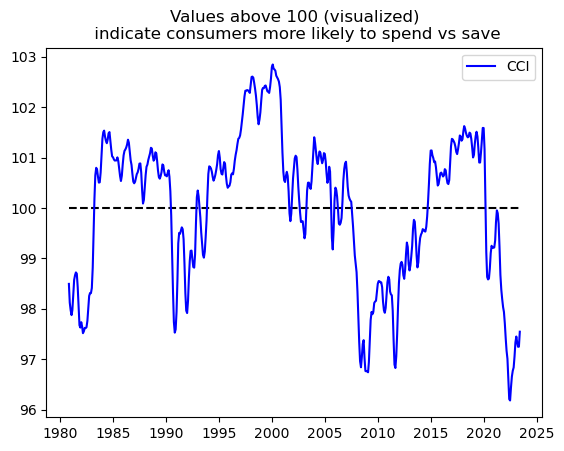

In [52]:
# Visualizing trends for `CCI Value`
plt.plot(hundred_line, color='black', linestyle='--')
plt.plot(df_economics[features_to_plot[0]], label='CCI', color='blue')
plt.title('Values above 100 (visualized)\n indicate consumers more likely to spend vs save')
plt.legend()
plt.show()

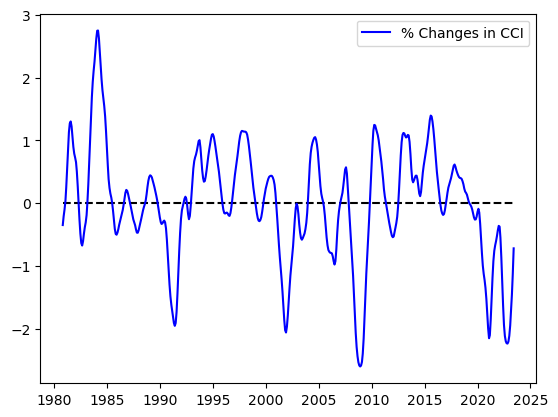

In [53]:
# Visualizing trends for `CCI Rolling Percent Change`
plt.plot(zero_line, color='black', linestyle='--')
plt.plot(df_economics[features_to_flag[0]], label='% Changes in CCI', color='blue')
plt.legend()
plt.show()

#### CPI

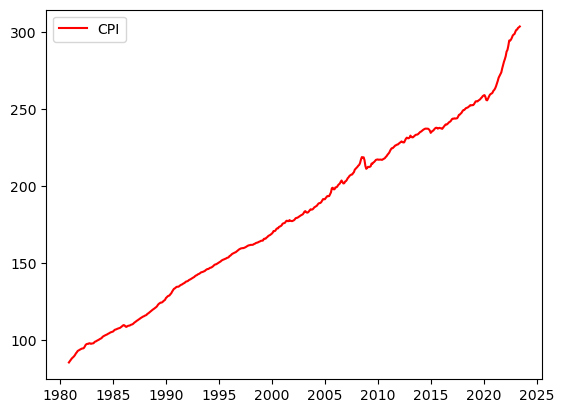

In [54]:
# Visualizing trends for `CPI Value`
plt.plot(df_economics[features_to_plot[1]], label='CPI', color='red')
plt.legend()
plt.show()

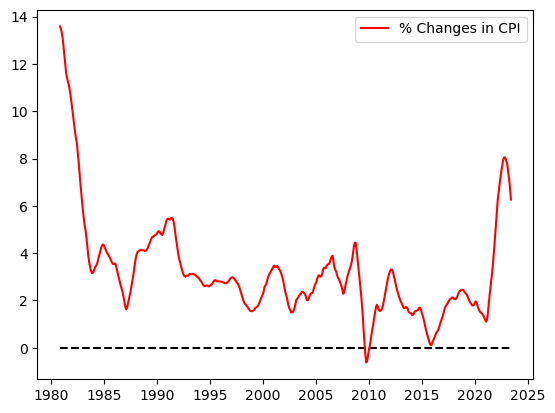

In [55]:
# Visualizing trends for `CPI Rolling Percent Change`
plt.plot(zero_line, color='black', linestyle='--')
plt.plot(df_economics[features_to_flag[1]], label='% Changes in CPI', color='red')
plt.legend()
plt.show()

#### Unemployment

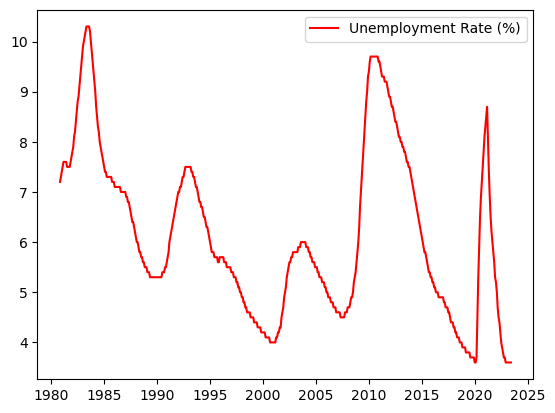

In [56]:
# Visualizing trends for `Unemployment Rate (%)`
plt.plot(df_economics[features_to_plot[2]], label='Unemployment Rate (%)', color='red')
plt.legend()
plt.show()

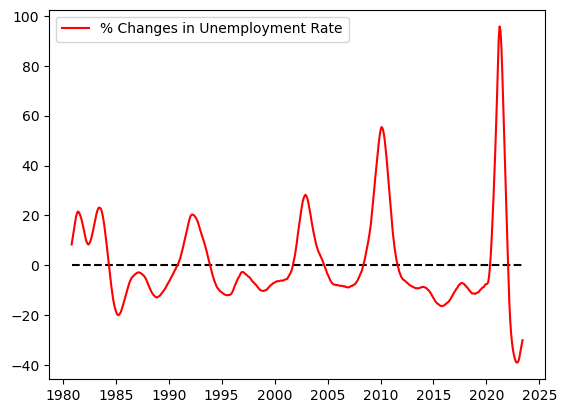

In [57]:
# Visualizing trends for `Unemployment Rate Rolling Percent Change`
plt.plot(zero_line, color='black', linestyle='--')
plt.plot(df_economics[features_to_flag[2]], label='% Changes in Unemployment Rate', color='red')
plt.legend()
plt.show()

#### Economic Climate

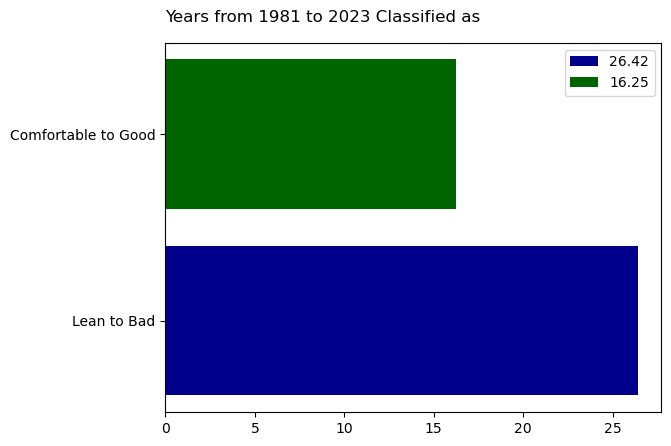

In [58]:
# Vizualizing total years classified in `Economic Climate`
plt.barh(
    y=df_economics['Economic Climate'].value_counts().index,
    width=df_economics['Economic Climate'].value_counts()/12,
    color=['darkblue', 'darkgreen'],
    label=['26.42', '16.25']
)
plt.title(
    'Years from 1981 to 2023 Classified as',
    loc='left',
    pad=15
)
plt.legend()
plt.show()

### Indexing

In [59]:
# Resetting the index to recreate `Date` for later concatenation
df_economics.reset_index(inplace=True)

## Combined Data

A combined dataset will need to be prepared for modeling

### Merging

With both `df_movies` and `df_economics` prepared, the two datasets can be merged into one final working DF

#### Indexing

The `df_movies` dataset will need to be set to a `Date` index, and the year and month will need to be extracted from the `Date` of the `df_economics` dataset

In [60]:
# Creating a 'Date' for a datetime index
df_movies['Date'] = pd.to_datetime({
    'year': df_movies['released_year'],
    'month': df_movies['released_month'],
    'day': df_movies['released_day']
})

# Setting `Date` as index
df_movies.set_index('Date', inplace=True)

# Ensuring index is sorted with ascending dates
df_movies.sort_index(inplace=True)

In [61]:
# Creating a `Year` and `Month` for concatenation
df_economics['Year'] = df_economics['Date'].dt.strftime('%Y').astype(int)
df_economics['Month'] = df_economics['Date'].dt.strftime('%m').astype(int)

# Renaming to `Year` and `Month` for concatenation
df_movies.rename(columns={
'released_year': 'Year',
'released_month': 'Month'
}, inplace=True)

#### Merging

Generating the final record counts before and after merging the two datasets

In [62]:
# Confirming total records before concatenation
records_total(df_economics)
records_total(df_movies)

Total records: 512
Total records: 15488


In [63]:
# Combining datasets through concatenation
df_combined = pd.merge(df_economics, df_movies, how='left', on=['Year', 'Month'])

# Confirming total records after concatenation
records_total(df_combined)

Total records: 12670


### EDA

Continuing EDA on the compiled DF

#### Target value

Concatenating the two engineered target values from the `df_movies` dataset with the engineered target from the `df_economics` dataset

In [64]:
# Creating the eventual `Target` for modeling
df_combined['Target'] = df_combined['critical_success'].astype(str) + ' ' +\
                        df_combined['financial_success'].astype(str) + ' ' +\
                        df_combined['Economic Climate'].astype(str)


#### Reducing features and dataset

Dropping uneeded features and removing `NaN` records

In [65]:
# Creating a list of features to drop
cols_to_drop = [
    'Date',
    'CCI Rolling Mean',
    'CPI Rolling Mean',
    'Unemployment Rate (%) Rolling Mean',
    'Year',
    'Month',
    'cast',
    'original_language',
    'director',
    'writers',
    'producers',
    'popularity', 
    'critical_success',
    'financial_success',
    'release_date',
    'released_day',
    'production_countries',
    'status',
    'spoken_languages'
]

# Dropping unneeded features
df_combined.drop(columns=cols_to_drop, inplace=True)

In [66]:
# Dropping `NaN` records
df_combined.dropna(inplace=True)

In [67]:
# Confirming total records after concatenation
print(f'Total records: {df_combined.shape[0]}')

Total records: 10381


#### Genres

Reducing the `genres` feature to a single value for the purposes of visualizations

*Note: In the cases where multiple genres are listed for a given movie, only the first listed genre will be retained*

In [68]:
# Confirming values of `genres`
df_combined['genres'].value_counts()

genres
Drama                                  853
Comedy                                 694
Horror                                 653
Documentary                            508
Comedy, Drama                          282
                                      ... 
Drama, Mystery, Documentary, Action      1
Adventure, Fantasy, Action, Horror       1
Music, Drama, Romance, Family            1
Family, Comedy, Music, TV Movie          1
Animation, Family, Fantasy, Comedy       1
Name: count, Length: 1744, dtype: int64

In [69]:
# Creating a working copy of `df_combined` to preserve modeling integirty of dataset
df_comb_vis = df_combined.copy()

In [70]:
# Splitting strings in `genres` into lists
df_comb_vis['genres'] = df_comb_vis['genres'].str.split(',')

# Seperating records with multiple `genres` into individual records
df_comb_vis = df_comb_vis.explode('genres')

# Stripping white spaces from `genres`
df_comb_vis['genres'] = df_comb_vis['genres'].str.strip()

# Reconfirming values of `genres`
df_comb_vis['genres'].value_counts()

genres
Drama              3879
Comedy             3475
Horror             2327
Thriller           2161
Action             1808
Romance            1247
Crime              1153
Science Fiction    1091
Adventure           964
Documentary         799
Family              782
Fantasy             707
Mystery             670
Animation           432
Music               353
History             214
War                 174
TV Movie            170
Western             124
Name: count, dtype: int64

In [71]:
# Identifying duplicate records in `df_comb_vis` by `id`
df_comb_dup = df_comb_vis[df_comb_vis.duplicated(subset=['id'], keep=False)]

# Confirming total records of `df_comb_dup`
records_total(df_comb_dup)

Total records: 19299


In [72]:
# Dropping duplicate records by `id`
df_comb_vis = df_comb_vis.drop_duplicates(subset=['id'], keep='first')

# Identifying remaining duplicate records in `df_comb_vis` by `id
df_comb_dup = df_comb_vis[df_comb_vis.duplicated(subset=['id'], keep=False)]

# Confirming total records of `df_comb_dup` and `df_comb_vis`
print('For `df_comb_dup`:')
records_total(df_comb_dup)
print('\nFor `df_comb_vis`:')
records_total(df_comb_vis)

For `df_comb_dup`:
Total records: 0

For `df_comb_vis`:
Total records: 10381


#### Visualizations

Generating visualizations for `df_combined`

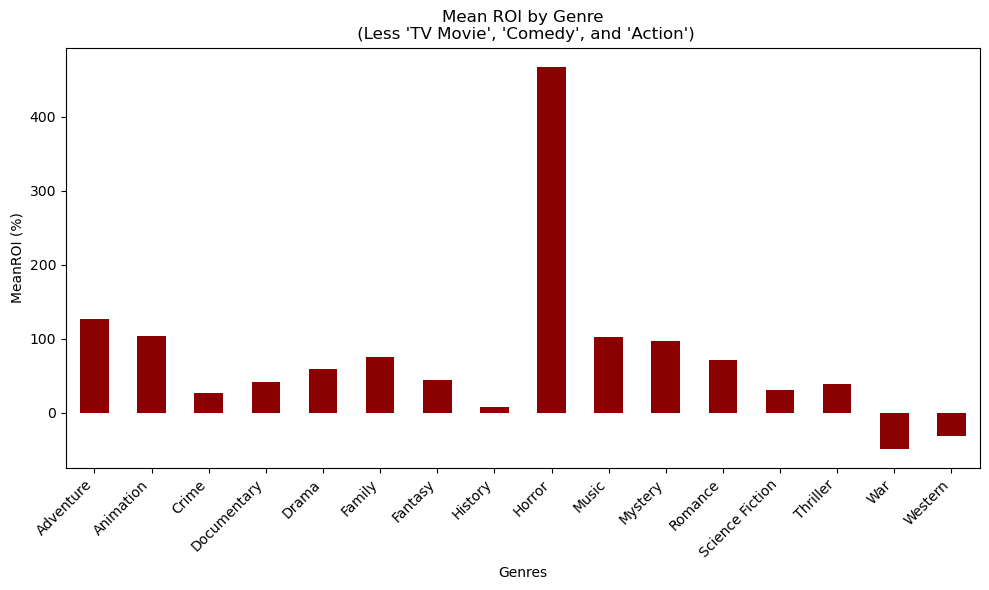

In [73]:
# Aggregating `roi` on `mean()` by `genres`
agg_roi_mean_genre_most = pd.DataFrame(
    df_comb_vis.loc[
        (df_comb_vis['genres'] != 'TV Movie') &
        (df_comb_vis['genres'] != 'Comedy') &
        (df_comb_vis['genres'] != 'Action')
    ].groupby('genres')['roi'].mean()
).reset_index()

# Plotting
ax = agg_roi_mean_genre_most.plot(
    kind='bar', x='genres', y='roi',
    figsize=(10, 6), legend=False, color='darkred'
)

# Adding title and labels
plt.title("Mean ROI by Genre\n (Less 'TV Movie', 'Comedy', and 'Action')")
plt.xlabel('Genres')
plt.ylabel('MeanROI (%)')
plt.xticks(rotation=45, ha='right')

# Format the y-axis to avoid scientific notation
ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()

# Show plot
plt.show()

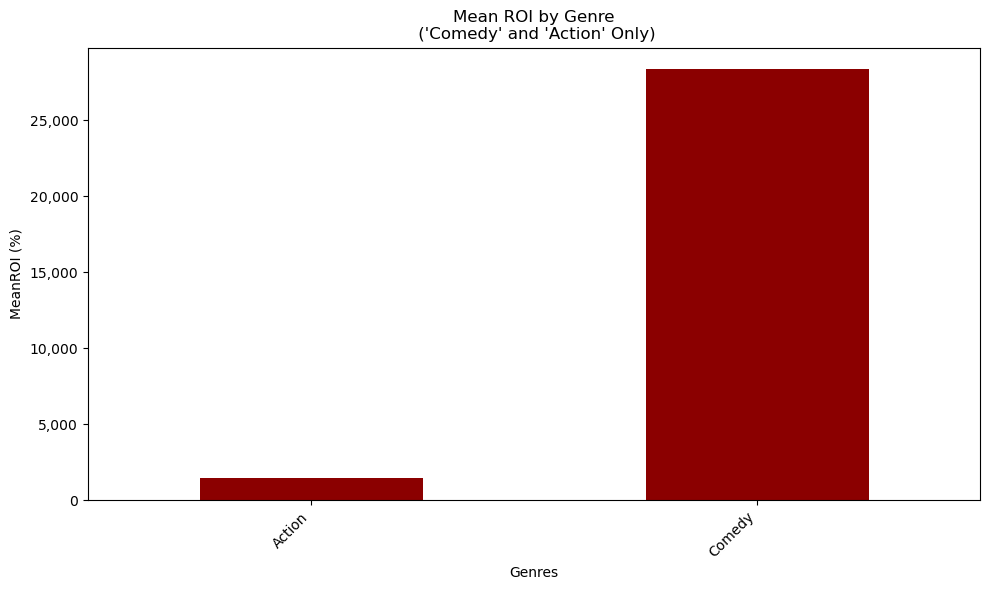

In [74]:
# Aggregating `roi` on `mean()` by `genres`
agg_roi_mean_genre_top_3 = pd.DataFrame(
    df_comb_vis.loc[
        (df_comb_vis['genres'] == 'Comedy') |
        (df_comb_vis['genres'] == 'Action')
    ].groupby('genres')['roi'].mean()
).reset_index()

# Plotting
ax = agg_roi_mean_genre_top_3.plot(
    kind='bar', x='genres', y='roi',
    figsize=(10, 6), legend=False, color='darkred'
)

# Adding title and labels
plt.title("Mean ROI by Genre\n ('Comedy' and 'Action' Only)")
plt.xlabel('Genres')
plt.ylabel('MeanROI (%)')
plt.xticks(rotation=45, ha='right')

# Format the y-axis to avoid scientific notation
ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()

# Show plot
plt.show()

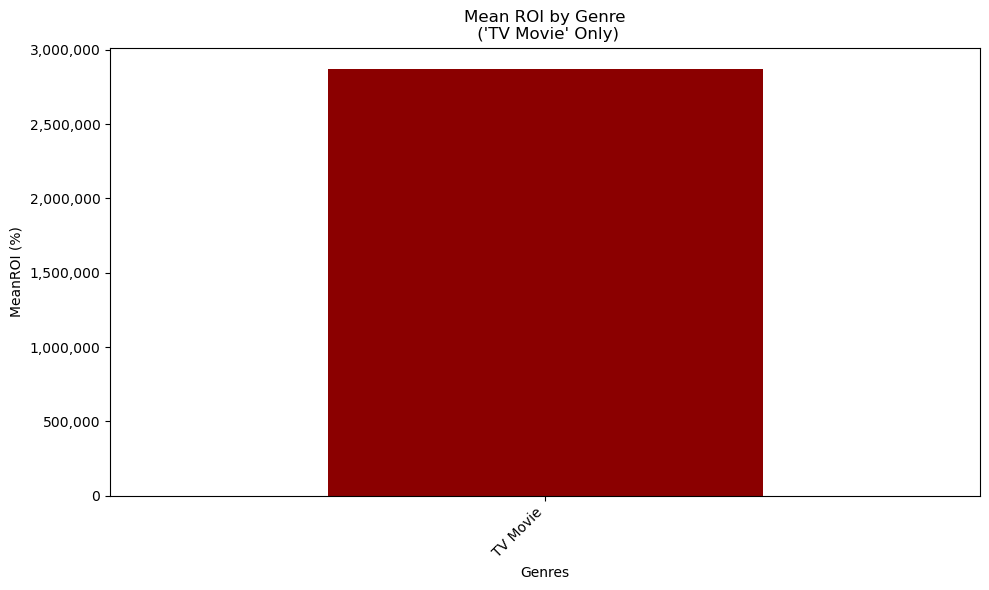

In [75]:
# Aggregating `roi` on `mean()` by `genres`
agg_roi_mean_genre_top_1 = pd.DataFrame(
    df_comb_vis.loc[
        (df_comb_vis['genres'] == 'TV Movie')
    ].groupby('genres')['roi'].mean()
).reset_index()

# Plotting
ax = agg_roi_mean_genre_top_1.plot(
    kind='bar', x='genres', y='roi',
    figsize=(10, 6), legend=False, color='darkred'
)

# Adding title and labels
plt.title("Mean ROI by Genre\n ('TV Movie' Only)")
plt.xlabel('Genres')
plt.ylabel('MeanROI (%)')
plt.xticks(rotation=45, ha='right')

# Format the y-axis to avoid scientific notation
ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()

# Show plot
plt.show()

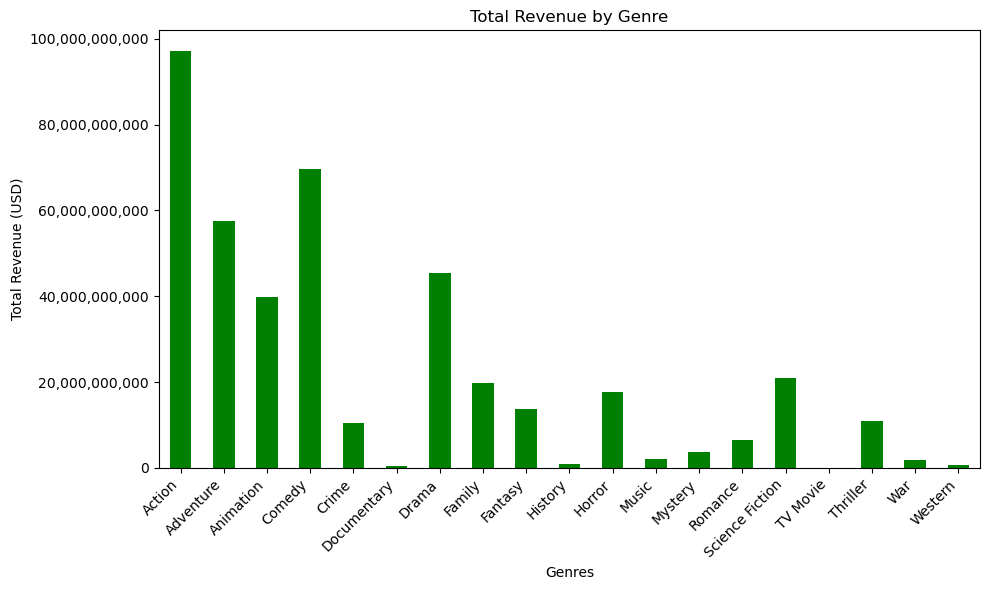

In [76]:
# Aggregating `revenue` on `sum()` by `genres`
agg_rev_sum_genre = pd.DataFrame(
    df_comb_vis.groupby('genres')['revenue'].sum()
).reset_index()

# Plotting
ax = agg_rev_sum_genre.plot(
    kind='bar', x='genres', y='revenue',
    figsize=(10, 6), legend=False, color='green'
)

# Adding title and labels
plt.title('Total Revenue by Genre')
plt.xlabel('Genres')
plt.ylabel('Total Revenue (USD)')
plt.xticks(rotation=45, ha='right')

# Format the y-axis to avoid scientific notation
ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()

# Show plot
plt.show()

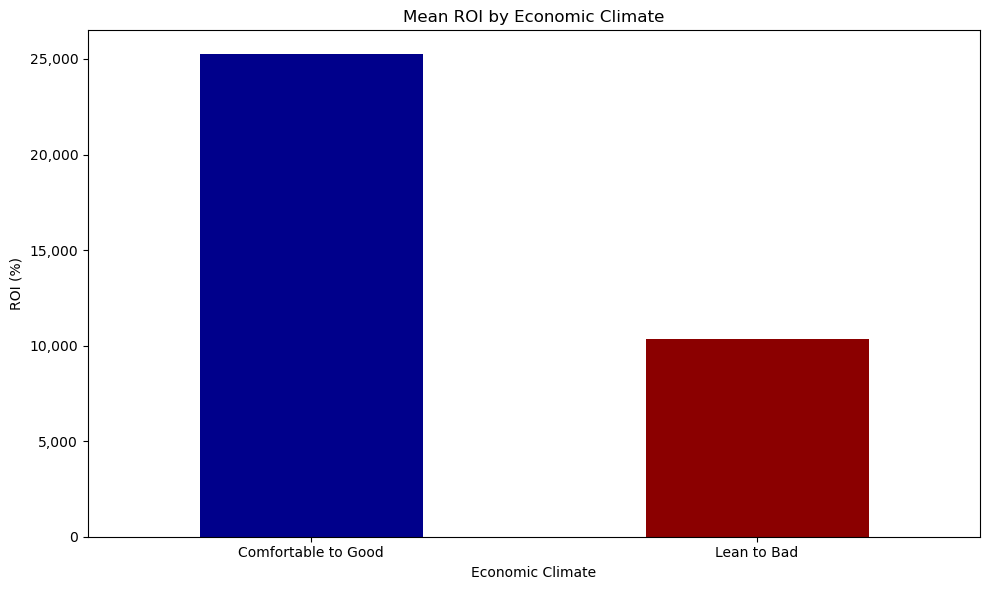

In [77]:
# Aggregating `roi` on `mean()` by `Economic Climate`
agg_roi_mean_economy = pd.DataFrame(
    df_comb_vis.groupby('Economic Climate')['roi'].mean()
).reset_index()

# Plotting
ax = agg_roi_mean_economy.plot(
    kind='bar', x='Economic Climate', y='roi',
    figsize=(10, 6), legend=False, color=['darkblue', 'darkred']
)

# Adding title and labels
plt.title('Mean ROI by Economic Climate')
plt.xlabel('Economic Climate')
plt.ylabel('ROI (%)')
plt.xticks(rotation=0)

# Format the y-axis to avoid scientific notation
ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()

# Show plot
plt.show()

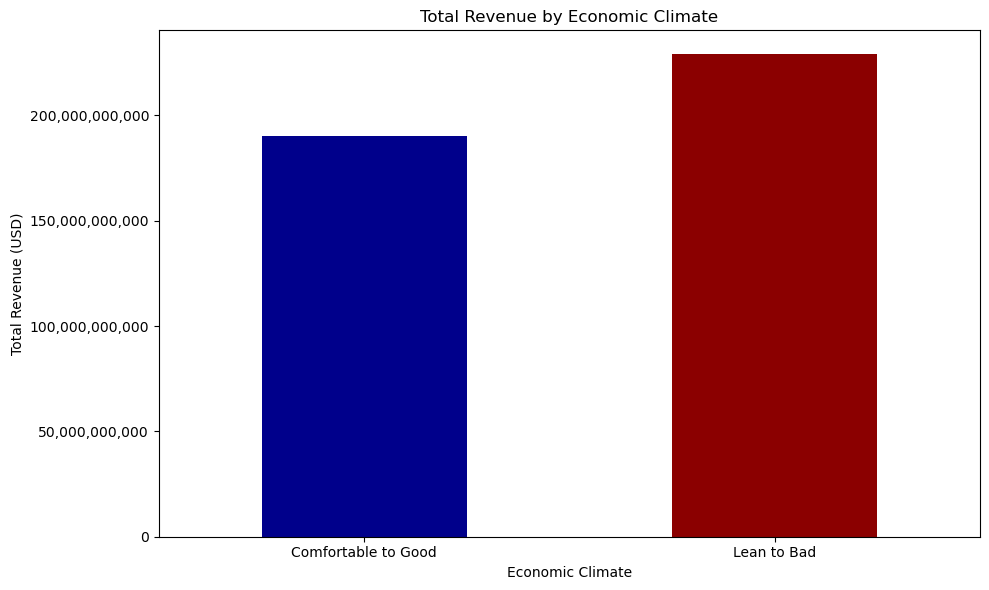

In [78]:
# Aggregating `revenue` on `sum()` by `Economic Climate`
agg_rev_sum_economy = pd.DataFrame(
    df_comb_vis.groupby('Economic Climate')['revenue'].sum()
).reset_index()

# Plotting
ax = agg_rev_sum_economy.plot(
    kind='bar', x='Economic Climate', y='revenue',
    figsize=(10, 6), legend=False, color=['darkblue', 'darkred']
)

# Adding title and labels
plt.title('Total Revenue by Economic Climate')
plt.xlabel('Economic Climate')
plt.ylabel('Total Revenue (USD)')
plt.xticks(rotation=0)

# Format the y-axis to avoid scientific notation
ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()

# Show plot
plt.show()

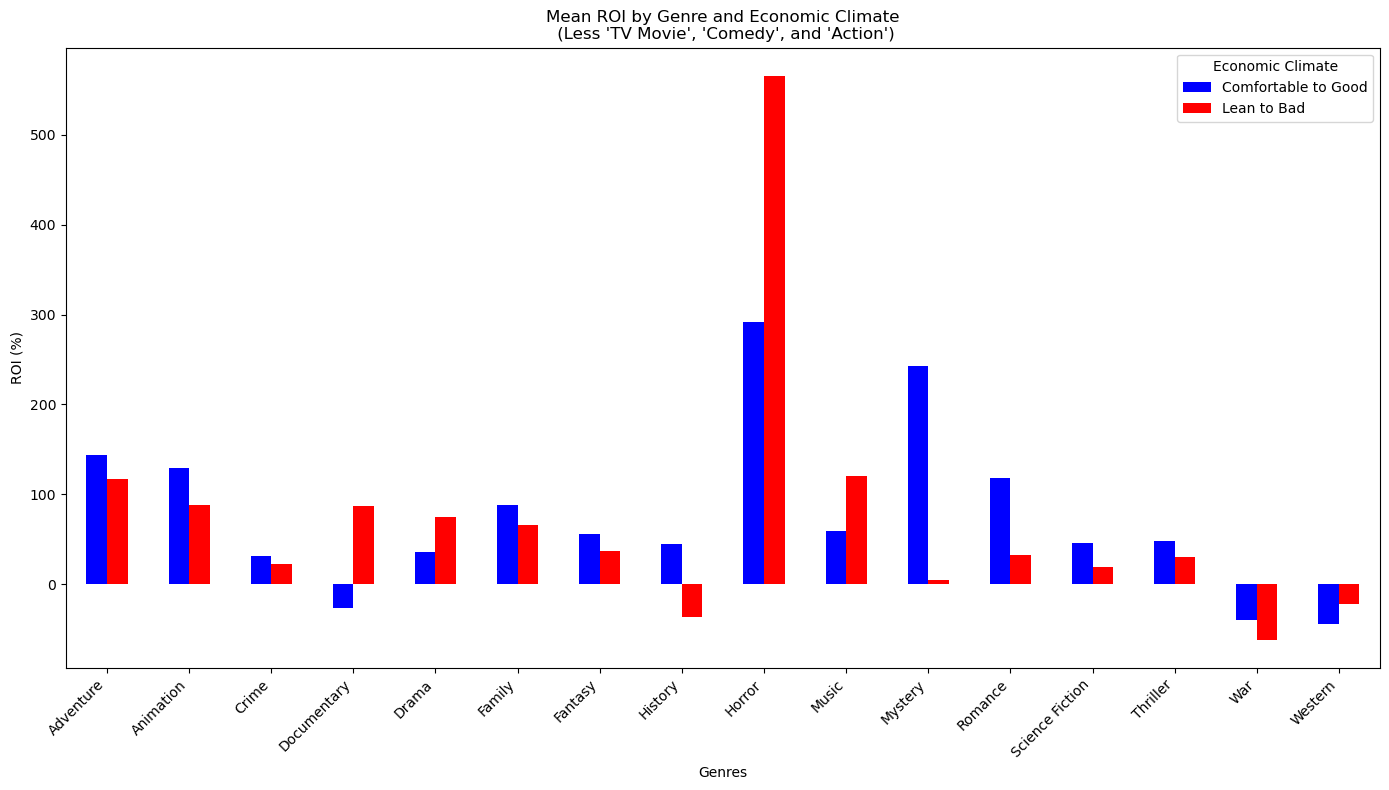

In [79]:
# Aggregating `roi` on `mean()` by `Economic Climate` and `genres`
agg_roi_mean_most = pd.DataFrame(
    df_comb_vis.loc[
        (df_comb_vis['genres'] != 'TV Movie') &
        (df_comb_vis['genres'] != 'Comedy') &
        (df_comb_vis['genres'] != 'Action')
    ].groupby(['Economic Climate', 'genres'])['roi'].mean()
).reset_index()

# Pivotting the table for plotting
pivot_table = agg_roi_mean_most.pivot(index='genres', columns='Economic Climate', values='roi')

# Plotting
ax = pivot_table.plot(kind='bar', figsize=(14, 8), color=['blue', 'red'])

# Adding title and labels
plt.title("Mean ROI by Genre and Economic Climate\n (Less 'TV Movie', 'Comedy', and 'Action')")
plt.xlabel('Genres')
plt.ylabel('ROI (%)')
plt.legend(title='Economic Climate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Formatting to avoid scientific notation
ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Displaying plot
plt.show()

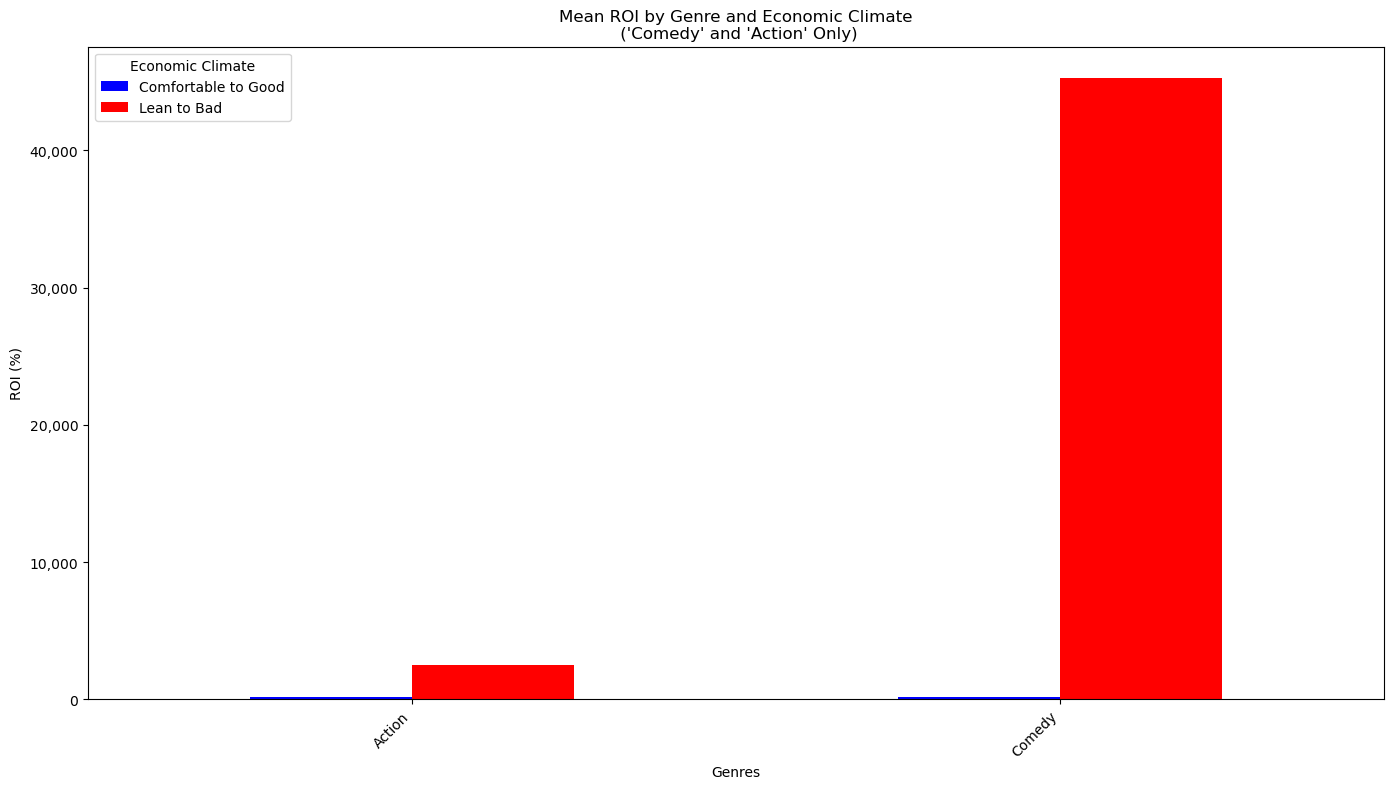

In [80]:
# Aggregating `roi` on `mean()` by `Economic Climate` and `genres`
agg_roi_mean_both_top_3 = pd.DataFrame(
    df_comb_vis.loc[
        (df_comb_vis['genres'] == 'Comedy') |
        (df_comb_vis['genres'] == 'Action')
    ].groupby(['Economic Climate', 'genres'])['roi'].mean()
).reset_index()

# Pivotting the table for plotting
pivot_table = agg_roi_mean_both_top_3.pivot(index='genres', columns='Economic Climate', values='roi')

# Plotting
ax = pivot_table.plot(kind='bar', figsize=(14, 8), color=['blue', 'red'])

# Adding title and labels
plt.title("Mean ROI by Genre and Economic Climate\n ('Comedy' and 'Action' Only)")
plt.xlabel('Genres')
plt.ylabel('ROI (%)')
plt.legend(title='Economic Climate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Formatting to avoid scientific notation
ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Displaying plot
plt.show()

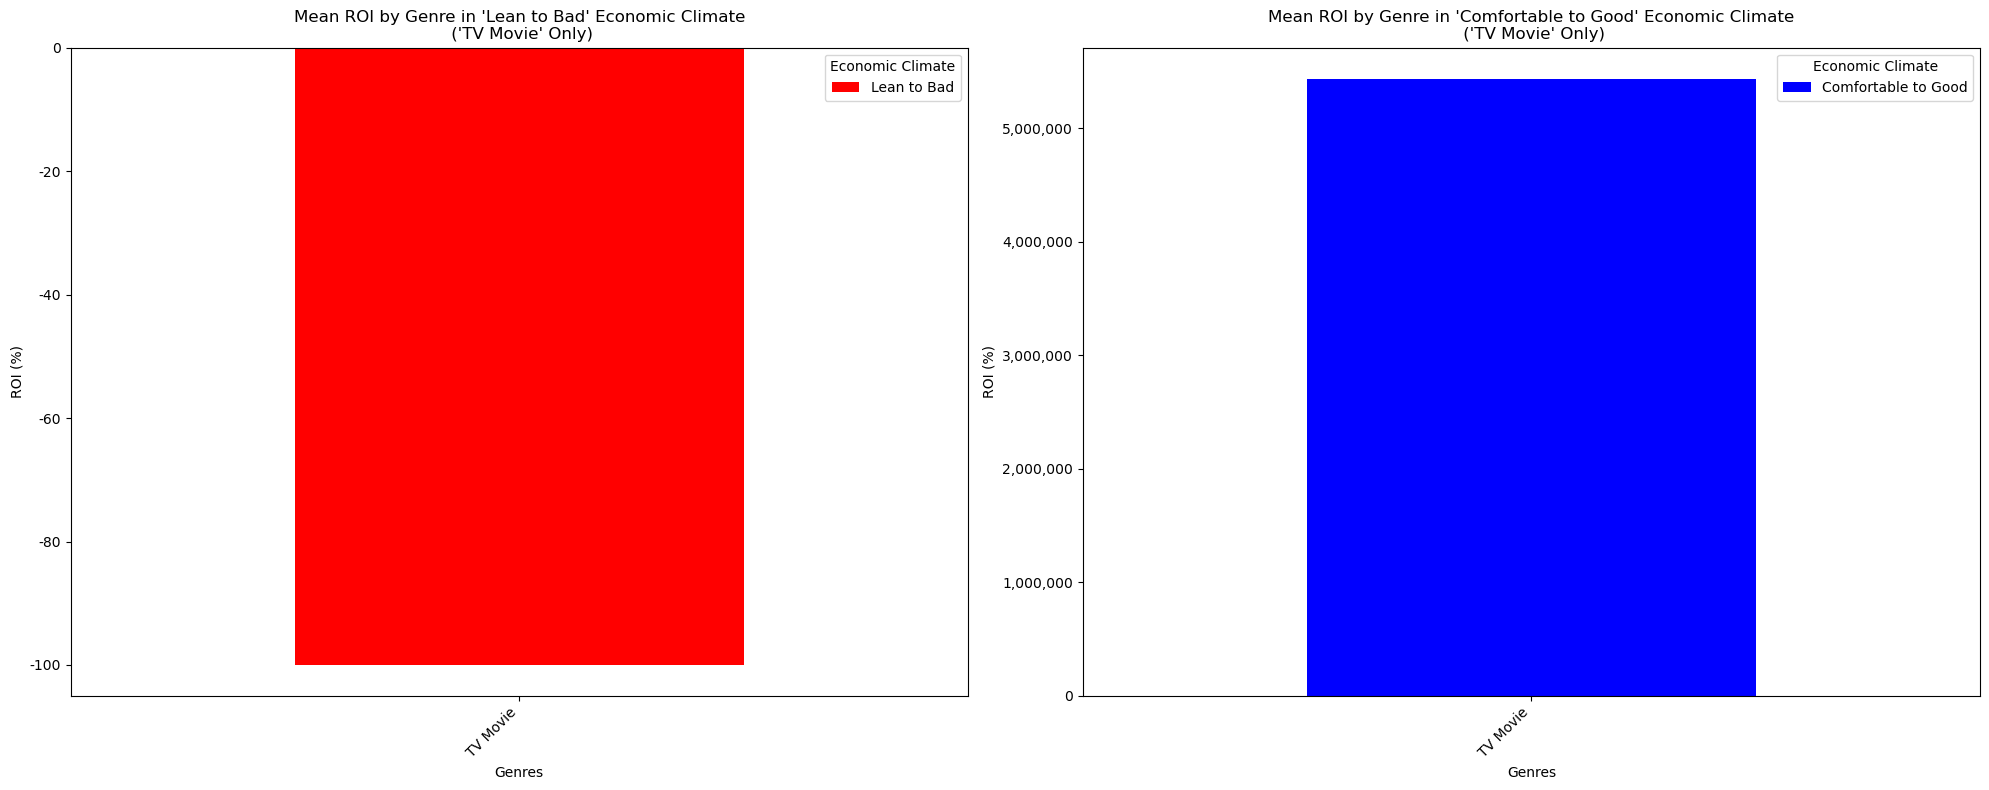

In [81]:
# Aggregating `roi` on `mean()` by `Economic Climate` and `genres`
agg_roi_mean_both_top_1_good = pd.DataFrame(
    df_comb_vis.loc[
        (df_comb_vis['genres'] == 'TV Movie') &
        (df_comb_vis['Economic Climate'] == 'Comfortable to Good')
    ].groupby(['Economic Climate', 'genres'])['roi'].mean()
).reset_index()

# Aggregating `roi` on `mean()` by `Economic Climate` and `genres`
agg_roi_mean_both_top_1_bad = pd.DataFrame(
    df_comb_vis.loc[
        (df_comb_vis['genres'] == 'TV Movie') &
        (df_comb_vis['Economic Climate'] == 'Lean to Bad')
    ].groupby(['Economic Climate', 'genres'])['roi'].mean()
).reset_index()

# Pivotting the tables for plotting
pivot_table_good = agg_roi_mean_both_top_1_good.pivot(index='genres', columns='Economic Climate', values='roi')
pivot_table_bad = agg_roi_mean_both_top_1_bad.pivot(index='genres', columns='Economic Climate', values='roi')
                                                
# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Plotting for 'Lean to Bad'
ax1 = pivot_table_bad.plot(kind='bar', ax=axes[0], color='red')
ax1.set_title("Mean ROI by Genre in 'Lean to Bad' Economic Climate\n ('TV Movie' Only)")
ax1.set_xlabel('Genres')
ax1.set_ylabel('ROI (%)')
ax1.legend(title='Economic Climate')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Plotting for 'Comfortable to Good'
ax2 = pivot_table_good.plot(kind='bar', ax=axes[1], color='blue')
ax2.set_title("Mean ROI by Genre in 'Comfortable to Good' Economic Climate\n ('TV Movie' Only)")
ax2.set_xlabel('Genres')
ax2.set_ylabel('ROI (%)')
ax2.legend(title='Economic Climate')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Adjusting layout
plt.tight_layout()

# Displaying plot
plt.show()

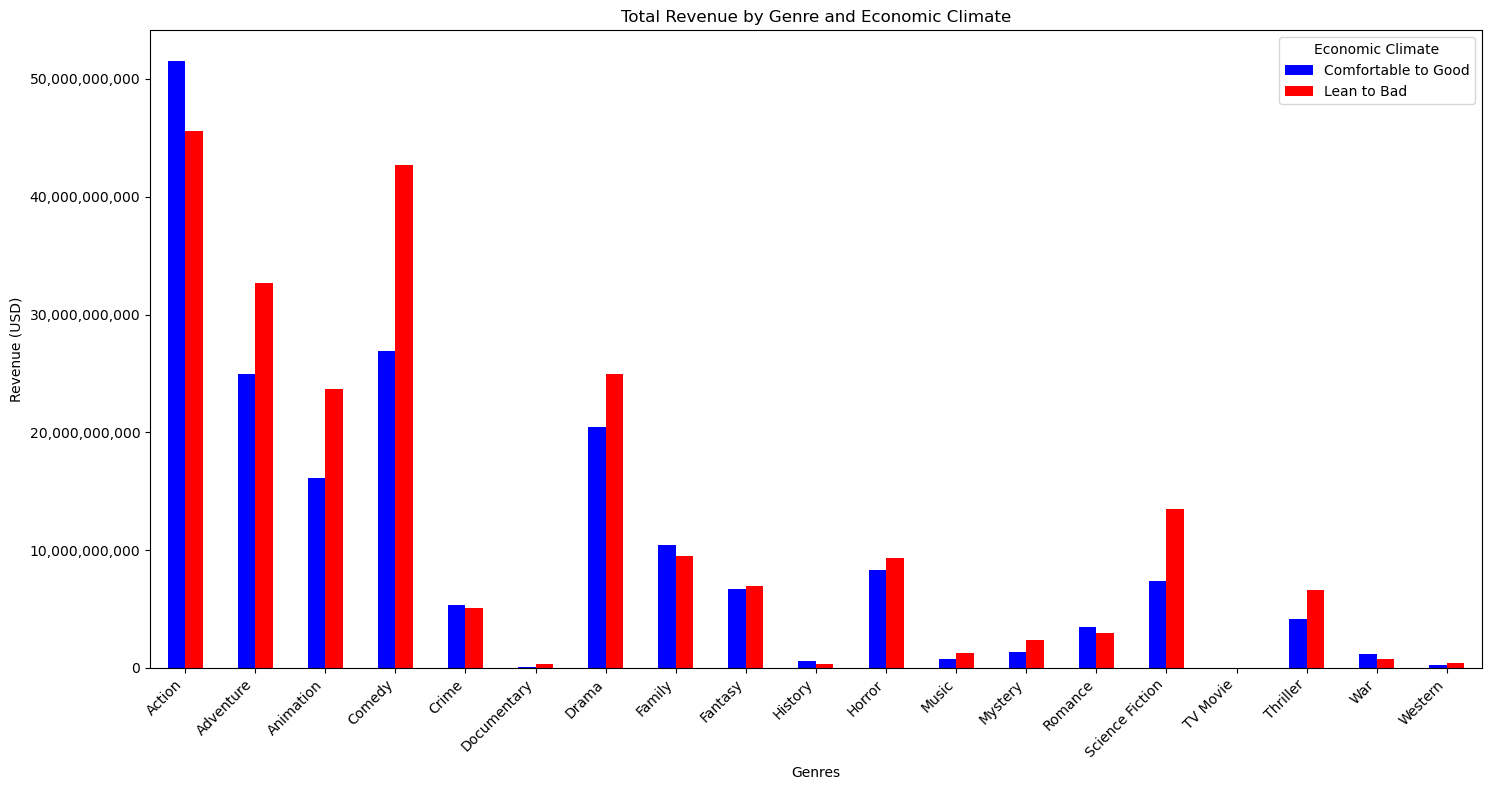

In [82]:
# Aggregating `revenue` on `sum()` by `Economic Climate` and `genres`
agg_rev_sum_both = pd.DataFrame(
    df_comb_vis.groupby(['Economic Climate', 'genres'])['revenue'].sum()
).reset_index()

# Pivotting the table for plotting
pivot_table = agg_rev_sum_both.pivot(index='genres', columns='Economic Climate', values='revenue')

# Plotting
ax = pivot_table.plot(kind='bar', figsize=(14, 8), color=['blue', 'red'])

# Adding title and labels
plt.title('Total Revenue by Genre and Economic Climate')
plt.xlabel('Genres')
plt.ylabel('Revenue (USD)')
plt.legend(title='Economic Climate')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Formatting to avoid scientific notation
ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# Displaying plot
plt.show()

#### Reducing features

Dropping the final uneeded feature before proceeding

In [83]:
# Dropping unneeded `Economic Climate`
df_combined.drop(columns=['Economic Climate', 'id'], inplace=True)

# **Train Test Splitting**

In [ ]:
# Defining features and target
X = df_combined.drop(columns='Target')
y = df_combined['Target']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

# **Scaling and Econding**

### Setup

Before proceeding to scaling and ecoding, a list of features for each needs to be established

In [ ]:
# Defining features to scale
col_to_scale = [
    'CCI Value', 'CCI Rolling Percent Change', 'CPI Value',
    'CPI Rolling Percent Change', 'Unemployment Rate (%)', 
    'Unemployment Rate Rolling Percent Change','vote_average', 'vote_count',
    'revenue','runtime','budget', 'roi'
]

# Defining features to encode
col_to_encode = [
    'CCI Rolling Percent Change Flag', 'CPI Rolling Percent Change Flag',
    'Unemployment Rate Rolling Percent Change Flag', 'title', 'original_title',
    'genres', 'production_companies'
]

### Scaling

With the presence of positive and negative values within our economics dataset, the `StandardScalar()` was chosen over the `MinMaxScalar()` to retain the nature of our source data

In [ ]:
# Creating an instance for `StandardScalar()`
scaler = StandardScaler()

# Fitting and transforming to `col_to_scale`
X_train_scaled = scaler.fit_transform(X_train[col_to_scale])
X_test_scaled = scaler.transform(X_test[col_to_scale])

# Converting results to DF for later concatenation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_to_scale)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_to_scale)

### Encoding

Encoding will be accomplished by two encoders; one for the encoded `X` data and one for the `y` target

#### OneHotEncoder()

For our non-numeric features, `OneHotEncoder()` was selected as the most efficient method to encode our data

In [ ]:
# Creating an instance for `OneHotEncoder()` for `X_train[col_to_encode]`
encoder_x = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fitting to `col_to_encode`
encoder_x.fit(X_train[col_to_encode])

# Transforming `X_train[col_to_encode]` and `X_test[col_to_encode]`
X_train_encoded = encoder_x.transform(X_train[col_to_encode])
X_test_encoded = encoder_x.transform(X_test[col_to_encode])

# Converting results to DF for later concatenation
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder_x.get_feature_names_out())
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder_x.get_feature_names_out())

#### Concatenation

Combining the scaled and encoded featuers to a sing set each for training and testing

In [ ]:
# Concatenating the `col_to_scale` with `col_to_encode` for `X_train` and `X_test`
X_train = pd.concat([X_train_scaled, X_train_encoded], axis=1)
X_test = pd.concat([X_test_scaled, X_test_encoded], axis=1)

# Confirming total records after concatenation
print(f'Total X records: {X_train.shape[0] + X_test.shape[0]}')

#### LabelEncoder()

After poorer performance with `OneHotEncoder()`, the `LabelEncoder()` was selected for our `y` target to better serve the purposes of our modeling

In [ ]:
# Creating an instance for `OneHotEncoder()` for `y_train`
encoder_y = LabelEncoder()

#Fitting
encoder_y.fit(y_train.values.ravel())

# Transforming `y_train` and `y_test`
y_train_encoded = encoder_y.transform(y_train.values.ravel())
y_test_encoded = encoder_y.transform(y_test.values.ravel())

# **Modeling**

Several models will be run to gauge which is best for predicting our `y` target of combined critical and financial success, as well as the economic climate of the time

## LogisticRegression()

Serving as a baseline, all other modeled results will be compared to the performance of this model

### Model

In [ ]:
# Declaring an instace of `LogisticRegression()`
logistic_regression_model = LogisticRegression(max_iter=500, solver='lbfgs')

### Fit

In [ ]:
# Fiting the model to the training data
logistic_regression_model.fit(X_train, y_train_encoded)

### Predict

In [ ]:
# Generating predictions using the test data
lr_predictions = logistic_regression_model.predict(X_test)

# Reviewing predictions
lr_predictions

### Scoring

#### Training and testing scores

In [ ]:
# Displaying model scores
print(f'Training score: {logistic_regression_model.score(X_train, y_train_encoded)}')
print(f'Testing score: {logistic_regression_model.score(X_test, y_test_encoded)}')

#### Accuracy and precision

In [ ]:
# Displaying the accuracy and precision scores
print('Accuracy score:')
print(accuracy_score(y_test_encoded, lr_predictions))
print('\nPrecision score:')
print(precision_score(y_test_encoded, lr_predictions, average='weighted', zero_division=1))

### Results

Training score: 0.9809890815671163

Testing score: 0.7773497688751926

* Acc: 0.7773497688751926
* Prc: 0.793423523704172

## KNeighborsClassifier()

### Untuned model

#### Model fit predict

In [ ]:
# Creating an untuned instance of `KNeighborsClassifier()`
untuned_model = KNeighborsClassifier()

# Fiting the model to the training data
untuned_model.fit(X_train, y_train_encoded)

# Generating predictions using the test data
untuned_y_test_pred = untuned_model.predict(X_test)

# Displaying model scores
print('Accuracy score:')
print(accuracy_score(y_test_encoded, untuned_y_test_pred))
print('\nPrecision score:')
print(precision_score(y_test_encoded, untuned_y_test_pred, average='weighted', zero_division=0))

#### PCA

In [ ]:
# Instantiatin and instance of `PCA` and declaring the number of PCA variables
# to retain maximum variance
pca = PCA(n_components=1, svd_solver='randomized')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#### PCA model fit predict

In [ ]:
# Creating an untuned instance of `KNeighborsClassifier()`
untuned_model = KNeighborsClassifier()

# Fiting the model to the PCA training data
untuned_model.fit(X_train_pca, y_train_encoded)

# Generating predictions using the PCA test data
untuned_y_test_pred = untuned_model.predict(X_test_pca)

# Displaying model scores
print('Accuracy score:')
print(accuracy_score(y_test_encoded, untuned_y_test_pred))
print('\nPrecision score:')
print(precision_score(y_test_encoded, untuned_y_test_pred, average='weighted', zero_division=0))

### Finding best K value

#### Visualization

Respect the noodle!

In [ ]:
# Create a KNN classfier to loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 40, 2):
    loop_model = KNeighborsClassifier(n_neighbors=k)
    loop_model.fit(X_train, y_train_encoded)
    train_score = loop_model.score(X_train, y_train_encoded)
    test_score = loop_model.score(X_test, y_test_encoded)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
# Plotting the results
plt.plot(range(1, 40, 2), train_scores, marker='o', label="training scores")
plt.plot(range(1, 40, 2), test_scores, marker="x", label="testing scores")
plt.xlabel("k neighbors")
plt.ylabel("accuracy score")
plt.legend()
plt.show()

#### Best K model fit predict

`k=23` was chosen as it provides the best accuracy where the classifier is not overfitting

In [ ]:
# Creating an untuned instance of `KNeighborsClassifier()` using best `k` value
loop_model = KNeighborsClassifier(n_neighbors=23)

# Fiting the model to the training data
loop_model.fit(X_train, y_train_encoded)

# Generating predictions using the test data
loop_y_test_pred = loop_model.predict(X_test)

# Displaying model scores
print('Accuracy score:')
print(accuracy_score(y_test_encoded, loop_y_test_pred))
print('\nPrecision score:')
print(precision_score(y_test_encoded, loop_y_test_pred, average='weighted', zero_division=0))

### Grid 

The grid search below used to hyperparameter tune the KNN Classifier provided a `k` value of **17**, with an accurancy score of **0.6854206807964033**

*Note: The code has been commented out code because it took 24min to run*

In [ ]:
# # Create a grid search KNN classifier
# grid_model = KNeighborsClassifier()

# # Define the parameter grid tuned KNN classifier
# param_grid = {'n_neighbors': list(range(1, 25, 2)),
#             'weights': ['uniform', 'distance'],
#             'leaf_size': [10, 50, 100, 500]
# }

# # Create a GridSearchCV model
# grid = GridSearchCV(grid_model, param_grid, verbose=3)

# # Fit the model by using the grid search estimator.
# # This will take the KNN model and try each combination of parameters.
# grid.fit(X_train, y_train_encoded)

# # Best parameter and score
# print(f"Best k: {grid.best_params_['n_neighbors']}")
# print(f"Best cross-validated accuracy: {grid.best_score_}")

### Results

Untuned:

* Acc: 0.676040061633282
* Prc: 0.6457813274107254

PCA untuned:

* Acc: 0.24807395993836673
* Prc: 0.22671758347128645

Loop at k=23:

* Acc: 0.6818181818181818
* Prc: 0.6316962265350805

Best K: 17

Cross-validated Acc: 0.6854206807964033

## AdaBoostClassifier()

### Model

In [ ]:
# Declaring an `AdaBoostClassifier` model
ada_model = AdaBoostClassifier(algorithm='SAMME', random_state=1)

### Fit

In [ ]:
# Fitting the model
ada_model.fit(X_train, y_train_encoded)

### Predict

In [ ]:
# Predicting with the model
ada_pred = ada_model.predict(X_test)

# Reviewing predictions
ada_pred

### Scoring

#### Training and testing scores

In [ ]:
# Displaying model scores
print(f'Training score: {ada_model.score(X_train, y_train_encoded)}')
print(f'Testing score: {ada_model.score(X_test, y_test_encoded)}')

#### Accuracy and precision

In [ ]:
# Displaying the accuracy and precision scores
print('Accuracy score:')
print(accuracy_score(y_test_encoded, ada_pred))
print('\nPrecision score:')
print(precision_score(y_test_encoded, ada_pred, average='weighted', zero_division=0))

### Results

Training score: 0.3892100192678227

Testing score: 0.3709553158705701

* Acc: 0.3709553158705701
* Prc: 0.16592403022145988

## RandomForestClassifier()

### Model

In [ ]:
# Declaring an instace of `RandomForestClassifier()`
random_forest_model = RandomForestClassifier(random_state=1)

### Fit

In [ ]:
# Fiting the model to the training data
random_forest_model.fit(X_train, y_train_encoded)

### Predict

In [ ]:
# Generating predictions using the test data
RFM_pred = random_forest_model.predict(X_test)

# Reviewing predictions
RFM_pred

### Scoring

#### Training and testing scores

In [ ]:
# Displaying model scores
print(f'Training score: {random_forest_model.score(X_train, y_train_encoded)}')
print(f'Testing score: {random_forest_model.score(X_test, y_test_encoded)}')

#### Accuracy and precision

In [ ]:
# Displaying the accuracy and precision scores
print('Accuracy score:')
print(accuracy_score(y_test_encoded, RFM_pred))
print('\nPrecision score:')
print(precision_score(y_test_encoded, RFM_pred, average='weighted', zero_division=1))

### Results

Training score: 1.0

Testing score: 0.8035439137134053

* Acc: 0.8035439137134053
* Prc: 0.8360129287675775

## LinearRegression()

#### Setup

Before proceeding to scaling and ecoding, a list of features for each needs to be established

In [111]:
# Defining features to scale
col_to_scale_lr = [
    'CCI Value', 'CCI Rolling Percent Change', 'CPI Value',
    'CPI Rolling Percent Change', 'Unemployment Rate (%)', 
    'Unemployment Rate Rolling Percent Change','vote_average', 'vote_count',
    'revenue','runtime','budget'
]

# Defining features to encode
col_to_encode_lr = [
    'CCI Rolling Percent Change Flag', 'CPI Rolling Percent Change Flag',
    'Unemployment Rate Rolling Percent Change Flag', 'title', 'original_title',
    'genres', 'production_companies'
]

col_for_X = [
    'CCI Value', 'CCI Rolling Percent Change', 'CPI Value',
    'CPI Rolling Percent Change', 'Unemployment Rate (%)', 
    'Unemployment Rate Rolling Percent Change','vote_average', 'vote_count',
    'revenue','runtime','budget', 'CCI Rolling Percent Change Flag',
    'CPI Rolling Percent Change Flag', 'Unemployment Rate Rolling Percent Change Flag',
    'title', 'original_title', 'genres', 'production_companies'
]

### Train test split

Creating a subset of the previous `train_test_split`

In [109]:
df_combined.shape

(10381, 20)

In [124]:
# Defining features and target
X_lr = df_combined[col_for_X]
y_lr = df_combined['roi'].values.reshape(-1, 1)

# Confirming shapes
print("Shape: ", X_lr.shape, y_lr.shape)

Shape:  (10381, 18) (10381, 1)


In [125]:
# Splitting the data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, random_state=13)

### Scaling and Encoding

#### Scaling

With the presence of positive and negative values within our economics dataset, the `StandardScalar()` was chosen over the `MinMaxScalar()` to retain the nature of our source data

In [126]:
# Creating an instance for `StandardScalar()`
scaler_lr = StandardScaler()

# Fitting and transforming to `col_to_scale`
X_train_scaled_lr = scaler_lr.fit_transform(X_train_lr[col_to_scale_lr])
X_test_scaled_lr = scaler_lr.transform(X_test_lr[col_to_scale_lr])

# Converting results to DF for later concatenation
X_train_scaled_lr = pd.DataFrame(X_train_scaled_lr, columns=col_to_scale_lr)
X_test_scaled_lr = pd.DataFrame(X_test_scaled_lr, columns=col_to_scale_lr)

#### OneHotEncoder()

For our non-numeric features, `OneHotEncoder()` was selected as the most efficient method to encode our data

In [127]:
# Creating an instance for `OneHotEncoder()` for `X_train[col_to_encode]`
encoder_x_lr = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fitting to `col_to_encode`
encoder_x_lr.fit(X_train_lr[col_to_encode_lr])

# Transforming `X_train[col_to_encode]` and `X_test[col_to_encode]`
X_train_encoded_lr = encoder_x_lr.transform(X_train_lr[col_to_encode_lr])
X_test_encoded_lr = encoder_x_lr.transform(X_test_lr[col_to_encode_lr])

# Converting results to DF for later concatenation
X_train_encoded_lr = pd.DataFrame(X_train_encoded_lr, columns=encoder_x_lr.get_feature_names_out())
X_test_encoded_lr = pd.DataFrame(X_test_encoded_lr, columns=encoder_x_lr.get_feature_names_out())

#### Concatenation

Combining the scaled and encoded featuers to a sing set each for training and testing

In [128]:
# Concatenating the `col_to_scale` with `col_to_encode` for `X_train` and `X_test`
X_train_lr = pd.concat([X_train_scaled_lr, X_train_encoded_lr], axis=1)
X_test_lr = pd.concat([X_test_scaled_lr, X_test_encoded_lr], axis=1)

# Confirming total records after concatenation
print(f'Total X records: {X_train_lr.shape[0] + X_test_lr.shape[0]}')

Total X records: 10381


### Model

In [129]:
# # Declaring an instace of `LinearRegression()`
model = LinearRegression()

### Fit

In [130]:
# Fiting the model to the training data subset
model.fit(X_train_lr, y_train_lr)

LinearRegression()

### Predict

In [131]:
# Generating predictions using the test data subset
predicted_roi = model.predict(X_test_lr)

# Reviewing predictions
predicted_roi

array([[ 20382.01842436],
       [-28554.4141998 ],
       [ 90202.19425459],
       ...,
       [ 19184.81727413],
       [ 12560.84377912],
       [-48947.99920675]])

### Scoring

In [132]:
# Displaying model scores
print("Mean Squared Error:", mean_squared_error(y_test_lr, predicted_roi))
print("R2 Score:", r2_score(y_test_lr, predicted_roi))

Mean Squared Error: 43298644487.0977
R2 Score: -0.08725857589736674


### Results

Mean Squared Error: 43298644487.0977

R2 Score: -0.08725857589736674

# Additional

Things Needed;

* Correlations?
* More visualizatoins?
* Tuning ran models?
* Anything else?

In [134]:
df_combined.columns

Index(['CCI Value', 'CCI Rolling Percent Change', 'CPI Value',
       'CPI Rolling Percent Change', 'Unemployment Rate (%)',
       'Unemployment Rate Rolling Percent Change',
       'CCI Rolling Percent Change Flag', 'CPI Rolling Percent Change Flag',
       'Unemployment Rate Rolling Percent Change Flag', 'title',
       'vote_average', 'vote_count', 'revenue', 'runtime', 'budget',
       'original_title', 'genres', 'production_companies', 'roi', 'Target'],
      dtype='object')

In [135]:
# Checking correlations for profits and economic indicators
df_combined[[
    'roi',
    'revenue',
    'CCI Value',
    'CPI Value',
    'Unemployment Rate (%)'
]].corr()

,roi,revenue,CCI Value,CPI Value,Unemployment Rate (%)
roi,1.000000,-0.004196,0.004489,0.006016,-0.009420
revenue,-0.004196,1.000000,0.046122,-0.039090,0.006135
CCI Value,0.004489,0.046122,1.000000,-0.366250,-0.280426
CPI Value,0.006016,-0.039090,-0.366250,1.000000,-0.281366
Unemployment Rate (%),-0.009420,0.006135,-0.280426,-0.281366,1.000000


# Findings

Best = Random Forest (no surprise there)

Hypothesis = Null?

# Citations and Licenses

## Citaions

### **Unemployment.csv**

Economic Policy Institute, *State of Working America Data Library*, “Unemployment”, 2024

## Licenses

### **TMBD_all_movies.csv**

Copyright 2024 __[Alan Vourc'h](https://www.kaggle.com/alanvourch)__

Licensed under the Apache License, Version 2.0 (the "License");
You may not use this file except in compliance with the License. You may obtain a copy of the License at

> __http://www.apache.org/licenses/LICENSE-2.0__

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

### **CCI_OECD.csv** and **US_inflation_rates.csv**

CCO: Public Domain